# Solving BDNK diffusion in $(1+1)$D with the Kurganov–Tadmor scheme

## Introduction

In this notebook we implement the Kurganov-Tadmor finite-volume scheme for the BDNK diffusion model in $(1+1)$D. The way this code works is the following:

1. Set up the spatial grid, and choose the final simulation time. Choose a function for the background temperature, $T(t,x)$, and evaluate the function at $t=0$ to obtain the initial profile for the temperature, $T(t=0,x)$. Also, choose a background velocity $v$ (with $-1< v < 1$).
2. Choose an initial condition for the density, $n(t=0,x)$.
3. Choose a mapping $f:n(t,x)\mapsto\alpha(t,x)$, and from $n(t=0,x)$, build the initial profile for the auxiliary field $\alpha(t=0,x)$, and from it, compute the initial profile of the spatial component of the N-field, $N_x(t=0,x)$.
4. Choose a mapping $g:\alpha(t,x)\mapsto\sigma(t,x)$, and from $\alpha(t=0,x)$, compute the initial profile of the transport coefficient, $\sigma(t=0,x)$. Also, choose a mapping $h:\sigma(t,x)\mapsto\lambda(t,x)$ (such that $\lambda(t,x)>\sigma(t,x)\,\forall t$), and from $\sigma(t=0,x)$, compute the initial profile of the relaxation timescale parameter, $\lambda(t=0,x)$.
5. Choose an initial condition for the current’s zeroth-component, $J^0(t=0,x)$.
6. From $N_x(t=0,x)$ compute the initial profile of the current’s spatial component, $J^x(t=0,x)$, and from $J^0(t=0,x)$ compute the initial profile of the zeroth-component of the N-field, $N_0(t=0,x)$.
7. While $t<t_{\rm end}$:
    1. From $\sigma(t,x)$ and $\lambda(t,x)$ compute the maximum local wave speed $c_{\rm max}(t)$, and from that, calculate the size of the next time step via the CFL condition (in BDNK, this quantity turns out to be constant).
    2. Time-step via the Kurganov–Tadmor scheme for one time-step only.
    3. Using the new $\alpha(t,x)$, update $\sigma(t,x)$, and using the new $\sigma(t,x)$, update $\lambda(t,x)$.
8. Save the data and plot the quantities of interest.

## Let's do it

### Step 1

We begin by importing the `numpy` module, and setting up the spatial grid in which we perform the simulation. We let $x\in(-L,L)$, where $L=50$. We choose a resolution `Nx` for the discretization of space, and then use a `linspace` to create the $x$-domain. We also define a quantity that represents the size of each cell in space (mathematically, our $dx$) by computing `dx = x[1] - x[0]`.

We use natural units ($c=\hbar=k_B=1$), so time and length both have units of ${\rm GeV}^{-1}$.

In [1]:
import os
import numpy as np
from numba import jit

# Space domain parameters
L = 50.0        # Half‐width of spatial domain, in GeV^-1. 50 GeV^-1 = 9.866 fm
Nx = 1000       # Number of spatial cells

# Time initialization and final simulation time
t = 0.0
t_end = 20.0     # in GeV^-1. 1 GeV^-1 = 6.58e-25 seconds.

# Build spatial grid
x = np.linspace(-L, L, Nx+1)  # Cell edges
dx = x[1] - x[0]              # Size of each space-step
xc = 0.5*(x[:-1] + x[1:])     # Positions of the centers of the cells

We also choose a temperature $T$ (in units of ${\rm GeV}$), and a background (dimensionless) velocity $-1<v<1$. We define too a $\gamma=\gamma(v)$ function. Everything from `def _BDNK_base_dir()` to `dx_tab = ...` is to import BDNK backgrounds.

In [2]:
BDNK_simulation = 2
epsT4_constant = 15.6268736
BDNK_t_end    = 20.0

# To use the BDNK backgrounds (third setup in the paper), we define the following functions:

def _BDNK_base_dir():
    here = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
    return os.path.join(here, "BDNK Background Simulations")

def _pick_BDNK_subfolder(base_dir: str, nsim: int) -> str:
    prefix = f"{nsim}_"
    candidates = [d for d in os.listdir(base_dir) if d.startswith(prefix) and os.path.isdir(os.path.join(base_dir, d))]
    if not candidates:
        raise FileNotFoundError(f"No folder starting with '{prefix}' in {base_dir}")
    candidates.sort()
    return os.path.join(base_dir, candidates[0])

def _load_BDNK_data(nsim: int):
    base = _BDNK_base_dir()
    folder = _pick_BDNK_subfolder(base, nsim)
    ep_path = os.path.join(folder, "ep(t,x).npy")
    v_path  = os.path.join(folder, "v(t,x).npy")
    if not os.path.exists(ep_path): raise FileNotFoundError(ep_path)
    if not os.path.exists(v_path):  raise FileNotFoundError(v_path)

    ep_tx = np.load(ep_path)
    v_tx  = np.load(v_path)
    if ep_tx.shape != v_tx.shape:
        raise ValueError(f"Shape mismatch: ep {ep_tx.shape} vs v {v_tx.shape}")

    Nt_data, Nx_data = ep_tx.shape

    t_axis = np.linspace(0.0, BDNK_t_end, Nt_data, dtype=np.float64)

    if np.allclose(ep_tx[:, 0], ep_tx[:, -1]) and np.allclose(v_tx[:, 0], v_tx[:, -1]):
        ep_tx = ep_tx[:, :-1]
        v_tx  = v_tx[:, :-1]
    Nx_data = ep_tx.shape[1]
    
    dx_data = 2.0 * L / Nx_data
    x0_data = -L + 0.5 * dx_data
    x_axis  = x0_data + dx_data * np.arange(Nx_data, dtype=np.float64)

    T_tx = (ep_tx.astype(np.float64) / epsT4_constant) ** 0.25
    v_tx = v_tx.astype(np.float64)

    return T_tx, v_tx, t_axis, x_axis

T_tab, v_tab, t_tab, x_tab = _load_BDNK_data(BDNK_simulation)

@jit(nopython=True, cache=False)
def _wrap_x_periodic(x, Lloc):
    
    twoL = 2.0 * Lloc
    y = x
    
    while y < -Lloc:
        y += twoL
    while y >= Lloc:
        y -= twoL
    return y

@jit(nopython=True, cache=False)
def _interp2_uniform_scalar(t, x, tab, t0, dt, Nt, x0, dx, Nx, Lloc):
    
    if t <= t0:
        it0 = 0
        wt  = 0.0
    else:
        tmax = t0 + dt * (Nt - 1)
        if t >= tmax:
            it0 = Nt - 1
            wt  = 0.0
        else:
            ft  = (t - t0) / dt
            it0 = int(np.floor(ft))
            wt  = ft - it0

    it1 = it0 if it0 == Nt - 1 else it0 + 1

    xp = _wrap_x_periodic(x, Lloc)
    fx = (xp - x0) / dx
    ix0 = int(np.floor(fx))
    wx  = fx - ix0

    ix0_mod = ((ix0 % Nx) + Nx) % Nx
    ix1_mod = (ix0_mod + 1) % Nx

    v00 = tab[it0, ix0_mod]
    v01 = tab[it0, ix1_mod]
    v10 = tab[it1, ix0_mod]
    v11 = tab[it1, ix1_mod]

    v0 = v00 + wx * (v01 - v00)
    v1 = v10 + wx * (v11 - v10)
    return v0 + wt * (v1 - v0)

Nt_tab = T_tab.shape[0]
Nx_tab = T_tab.shape[1]
t0_tab = t_tab[0]
dt_tab = (t_tab[-1] - t_tab[0]) / (Nt_tab - 1) if Nt_tab > 1 else 1.0
x0_tab = x_tab[0]
dx_tab = (x_tab[-1] - x_tab[0]) / (Nx_tab - 1) if Nx_tab > 1 else (2.0 * L)


@jit(nopython=True, cache=False)
def T_func(t, x):
    #return 0.3 * np.ones_like(x) # For example, turn on this line for an arbitrary temperature background
    
    # On the other hand, use the following for the BDNK background:
    out = np.empty_like(x)
    for i in range(x.size):
        out[i] = _interp2_uniform_scalar(t, x[i],
                                         T_tab,
                                         t0_tab, dt_tab, Nt_tab,
                                         x0_tab, dx_tab, Nx_tab,
                                         L)
    return out

@jit(nopython=True, cache=False)
def v_func(t, x):
    #return 0.0 * np.ones_like(x) # For example, turn on this line for an arbitrary temperature background
    
    # On the other hand, use the following for the BDNK background:
    out = np.empty_like(x)
    for i in range(x.size):
        out[i] = _interp2_uniform_scalar(t, x[i],
                                         v_tab,
                                         t0_tab, dt_tab, Nt_tab,
                                         x0_tab, dx_tab, Nx_tab,
                                         L)
    return out

@jit(nopython=True, cache=False)
def gamma_func(v):
    return 1.0 / np.sqrt(1 - v**2)

### Step 2

Let's now choose an initial density $n(t=0,x)$. $n$ has units of ${\rm GeV}^3$. For example, let $$n(t=0,x) = p\exp\left[-\left(\frac{qx}{L}\right)^2\right]+r,\quad\text{where}\quad p=0.2\,{\rm GeV}^3,\,q=7.0,\,r=1.0\,{\rm GeV}^3.$$

In [3]:
p, q, r = 0.2, 7.0, 1.0                    # Parameters for the initial condition

@jit(nopython=True, cache=False)
def n_t0_builder(xc):
    # First setup
    #return p * (np.exp(- (q * xc / L)**2)) + r

    # Second setup
    # sharpness = 60
    # return (1.1 - 0.1*np.tanh(sharpness*((4*xc/L)**2-1)))

    # Third setup
    return 1e-3*(p * (np.exp(- (q * xc / L)**2)) + r)

### Step 3

Now, let's use the defined initial density and the relation
$$n = N_c N_f\, T^3 \left( \frac{\alpha}{27} + \frac{\alpha^3}{243\,\pi^2} \right),$$
which can be solved for $\alpha$ as
$$
\alpha = 
\frac{
    \left(\frac{3}{2}\right)^{1/3} \pi^{2/3} \left( \sqrt{3} \sqrt{2187\, n^2 T^{12} N_c^4 N_f^4 + 4 \pi^2 T^{18} N_c^6 N_f^6} + 81 n T^6 N_c^2 N_f^2 \right)^{1/3}
}{
    T^3 N_c N_f
}
-
\frac{
    2^{1/3} 3^{2/3} \pi^{4/3} T^3 N_c N_f
}{
    \left( \sqrt{3} \sqrt{2187\, n^2 T^{12} N_c^4 N_f^4 + 4 \pi^2 T^{18} N_c^6 N_f^6} + 81 n T^6 N_c^2 N_f^2 \right)^{1/3}
}
,$$
to calculate
$\alpha(t=0,x)$
and then
$$N_x(t=0,x)=-\partial_x\alpha(t=0,x).$$
Here, $\alpha$ is dimensionless, and $N_x$ has units of ${\rm GeV}$, since, in general, $\partial_\mu$ has units of ${\rm GeV}$.

In [4]:
N_c, N_f = 3, 3

@jit(nopython=True, cache=False)
def alpha_from_n_func(n, T):
    a = T**3 * N_c * N_f
    b = np.sqrt(
        2187 * n**2 * T**12 * N_c**4 * N_f**4
        + 4 * np.pi**2 * a**6
    )
    c = 81 * n * a**2
    d = np.cbrt(np.sqrt(3) * b + c)

    term1 = (3/2)**(1/3) * np.pi**(2/3) * d / a
    term2 = 2**(1/3) * 3**(2/3) * np.pi**(4/3) * a / d

    return term1 - term2

@jit(nopython=True, cache=False)
def n_from_alpha_func(alpha, T):
    term1 = alpha / 27
    term2 = (alpha ** 3) / (243 * np.pi ** 2)
    return N_c * N_f * T**3 * (term1 + term2)

@jit(nopython=True, cache=False)
def roll1d(a, shift):
    n = a.size
    s = shift % n
    out = np.empty_like(a)
    if s == 0:
        out[:] = a
    else:
        out[:s] = a[-s:]
        out[s:] = a[:-s]
    return out

@jit(nopython=True, cache=False)
def roll2d_axis1(A, shift):
    m, n = A.shape
    s = shift % n
    out = np.empty_like(A)
    if s == 0:
        out[:, :] = A
    else:
        out[:, :s] = A[:, -s:]
        out[:, s:] = A[:, :-s]
    return out
    
@jit(nopython=True, cache=False)
def N_x_func(alpha, dx_local):
    return -(roll1d(alpha, -1) - roll1d(alpha, 1)) / (2.0 * dx_local)

### Step 4

Now, we choose a mapping $g:\alpha(t,x)\mapsto\sigma(t,x)$, and copmute the initial profile of the transport coefficient, $\sigma(t=0,x)$. $\sigma$ has units of ${\rm GeV}$. For example, let
$$
\sigma(T, \alpha) = \frac{C_B n}{T^2} \left[ \frac{1}{3} \coth \left( \alpha \right) - \frac{n T}{\varepsilon + P} \right].
,\quad\text{where}\quad C_B=\frac{1}{4\pi}\text{ or }C_B=0.4,
$$
and
$$
    P = \left[2(N_c^2 - 1)+\frac{7}{2}N_c N_f\right]\frac{\pi^2 T^4}{90} + N_c N_f \frac{\mu^2 T^2}{54} + N_c N_f\frac{\mu^4}{972 \pi^2}.
$$

In [5]:
C_B = 1/(4*np.pi) # Third setup
#C_B = 0.4        # First and second setup

@jit(nopython=True, cache=False)
def mu_func(alpha, T):
    return alpha * T
    
@jit(nopython=True, cache=False)
def pressure_func(alpha, T):
    mu = mu_func(alpha, T)
    term1 = (2*(N_c**2 -1) + 7/2 * N_c * N_f) * np.pi**2 * T**4 / 90
    term2 = N_c * N_f * mu**2 * T**2 / 54
    term3 = N_c * N_f * mu**4 / (972 * np.pi**2)
    return term1 +term2+term3

@jit(nopython=True, cache=False)
def sigma_func(alpha, T):
    mu = mu_func(alpha, T)
    n = n_from_alpha_func(alpha, T)
    P = pressure_func(alpha, T)
    eps = 3*P
    return C_B * n * (1/3 * 1/np.tanh(mu/T) - n*T/(eps+P)) / (T**2)

We also define a mapping $h:\sigma\mapsto\lambda$ via the relation

$$ c_{\rm ch}^2 = \sigma(t,x)/\lambda(t,x),\quad\text{where}\quad c_{\rm ch}\in(0,1) $$

(where $\lambda$ has units of ${\rm GeV}$), and compute the initial profile $\lambda(t=0,x)$.

In [6]:
cch = 0.9

@jit(nopython=True, cache=False)
def lambd_func(sigma):
    return sigma/(cch**2)

### Step 5

Let's now choose an **zeroth component for the initial current**, $J^0(t=0,x)$. $J^\mu$ has units of ${\rm GeV}^3$. For now, let it be given by $$J^0(t=0,x) = d\exp\left[-\left(\frac{fx}{L}\right)^2\right]+g,\quad\text{where}\quad d=0.05\,{\rm GeV},\,f=10.0,\,g=1.05\,{\rm GeV}.$$

In [7]:
d, f, g = 0.05, 10.0, 1.05                    # Parameters for the initial condition

@jit(nopython=True, cache=False)
def J0_t0_builder(xc):
    # First setup
    #return d * np.exp(- (f * xc / L)**2) + g
    
    # Second setup
    #return np.ones_like(xc)*g

    # Third setup
    return 1e-3*np.ones_like(xc)*g

### Step 6

Now, using $J^0(t=0,x)$ (in code, `J0_t0`), we compute the **zeroth component of the initial N-field**, $N_0(t=0,x)$, as follows:
$$
    N_0 = \frac{-J^0 + n \gamma +(\sigma - \lambda) T \gamma^2 v^i N_i}{\sigma T + (\lambda - \sigma)T \gamma^2}.
$$
$N_\nu$ has units of ${\rm GeV}$.

In [8]:
@jit(nopython=True, cache=False)
def N_0_func(lambd, sigma, T, J0, n, N_x, v):
    gamma = gamma_func(v)
    num = -J0 + gamma * n + (sigma - lambd) * T * gamma**2 * v * N_x
    denom = sigma * T + (lambd - sigma) * T * gamma**2
    return num / denom

Also, using $N_x(t=0,x)$ (in code, `N_x_t0`), we compute the **spatial component of the initial current**, $J^x(t=0,x)$, as follows:
$$
    J^i = \gamma n v^i + \sigma T N^i + \gamma^2 T (-\lambda + \sigma) v^i v^j N_j + \gamma^2 T (-\lambda + \sigma) v^i N_0.
$$
In $(1+1)$ D, this is
$$
    J^x = \gamma n v + \sigma T N^x + \gamma^2 T (-\lambda + \sigma) v (v N^x + N_0).
$$

In [9]:
@jit(nopython=True, cache=False)
def Jx_func(n, sigma, lambd, T, N_x, N_0, v):
    gamma = gamma_func(v)
    return (gamma * n * v
            + sigma * T * N_x
            + gamma**2 * T * (sigma - lambd) * v * (v * N_x + N_0))

In [10]:
@jit(nopython=True, cache=False)
def make_IC(xc, dx_local, t=0.0):
    T_t0 = T_func(t, xc)
    v_t0 = v_func(t, xc)
    n_t0 = n_t0_builder(xc)
    alpha_t0 = alpha_from_n_func(n_t0, T_t0)
    N_x_t0 = N_x_func(alpha_t0, dx_local)
    sigma_t0 = sigma_func(alpha_t0, T_t0)
    lambd_t0 = lambd_func(sigma_t0)
    J0_t0 = J0_t0_builder(xc)
    U_t0 = np.vstack((J0_t0, alpha_t0, N_x_t0))
    return U_t0, T_t0, v_t0, sigma_t0, lambd_t0

U_t0, T_t0, v_t0, sigma_t0, lambd_t0 = make_IC(xc, dx)
J0_t0, alpha_t0, N_x_t0 = U_t0
n_t0 = n_from_alpha_func(alpha_t0, T_t0)
N_0_t0 = N_0_func(lambd_t0, sigma_t0, T_t0, J0_t0, n_t0, N_x_t0, v_t0)
Jx_t0 = Jx_func(n_t0, sigma_t0, lambd_t0, T_t0, N_x_t0, N_0_t0, v_t0)
mu_t0 = mu_func(alpha_t0, T_t0)

Before we move on, let's quickly set up a nice-looking plotting configuration using `seaborn`, but most importantly, let's perform a quick sanity check on every object we've built.

Domain, grid, and final simulation time:
  L      = 50.0 GeV^-1         = 9.866e+00 fm
  Nx     = 1000
  dx     = 1.000e-01 GeV^-1    = 1.973e-02 fm
  t_end  = 20.0 GeV^-1          = 1.316000e-23 s

Initial-density parameters:
  p = 0.2, q = 7.0, r = 1.0
  n(t=0,x):  min = 1.000e-03,  max = 1.200e-03
  α(t=0,x):  min = 4.759e-02,  max = 1.331e-01

Initial-current parameters:
  d = 0.05, f = 10.0, g = 1.05
  J⁰(t=0,x): min = 1.050e-03,  max = 1.050e-03
  Jˣ(t=0,x): min = -5.978e-08, max = 3.647e-04

Derived N-field:
  N₀(t=0,x): min = -5.696e-02, max = 1.045e-01


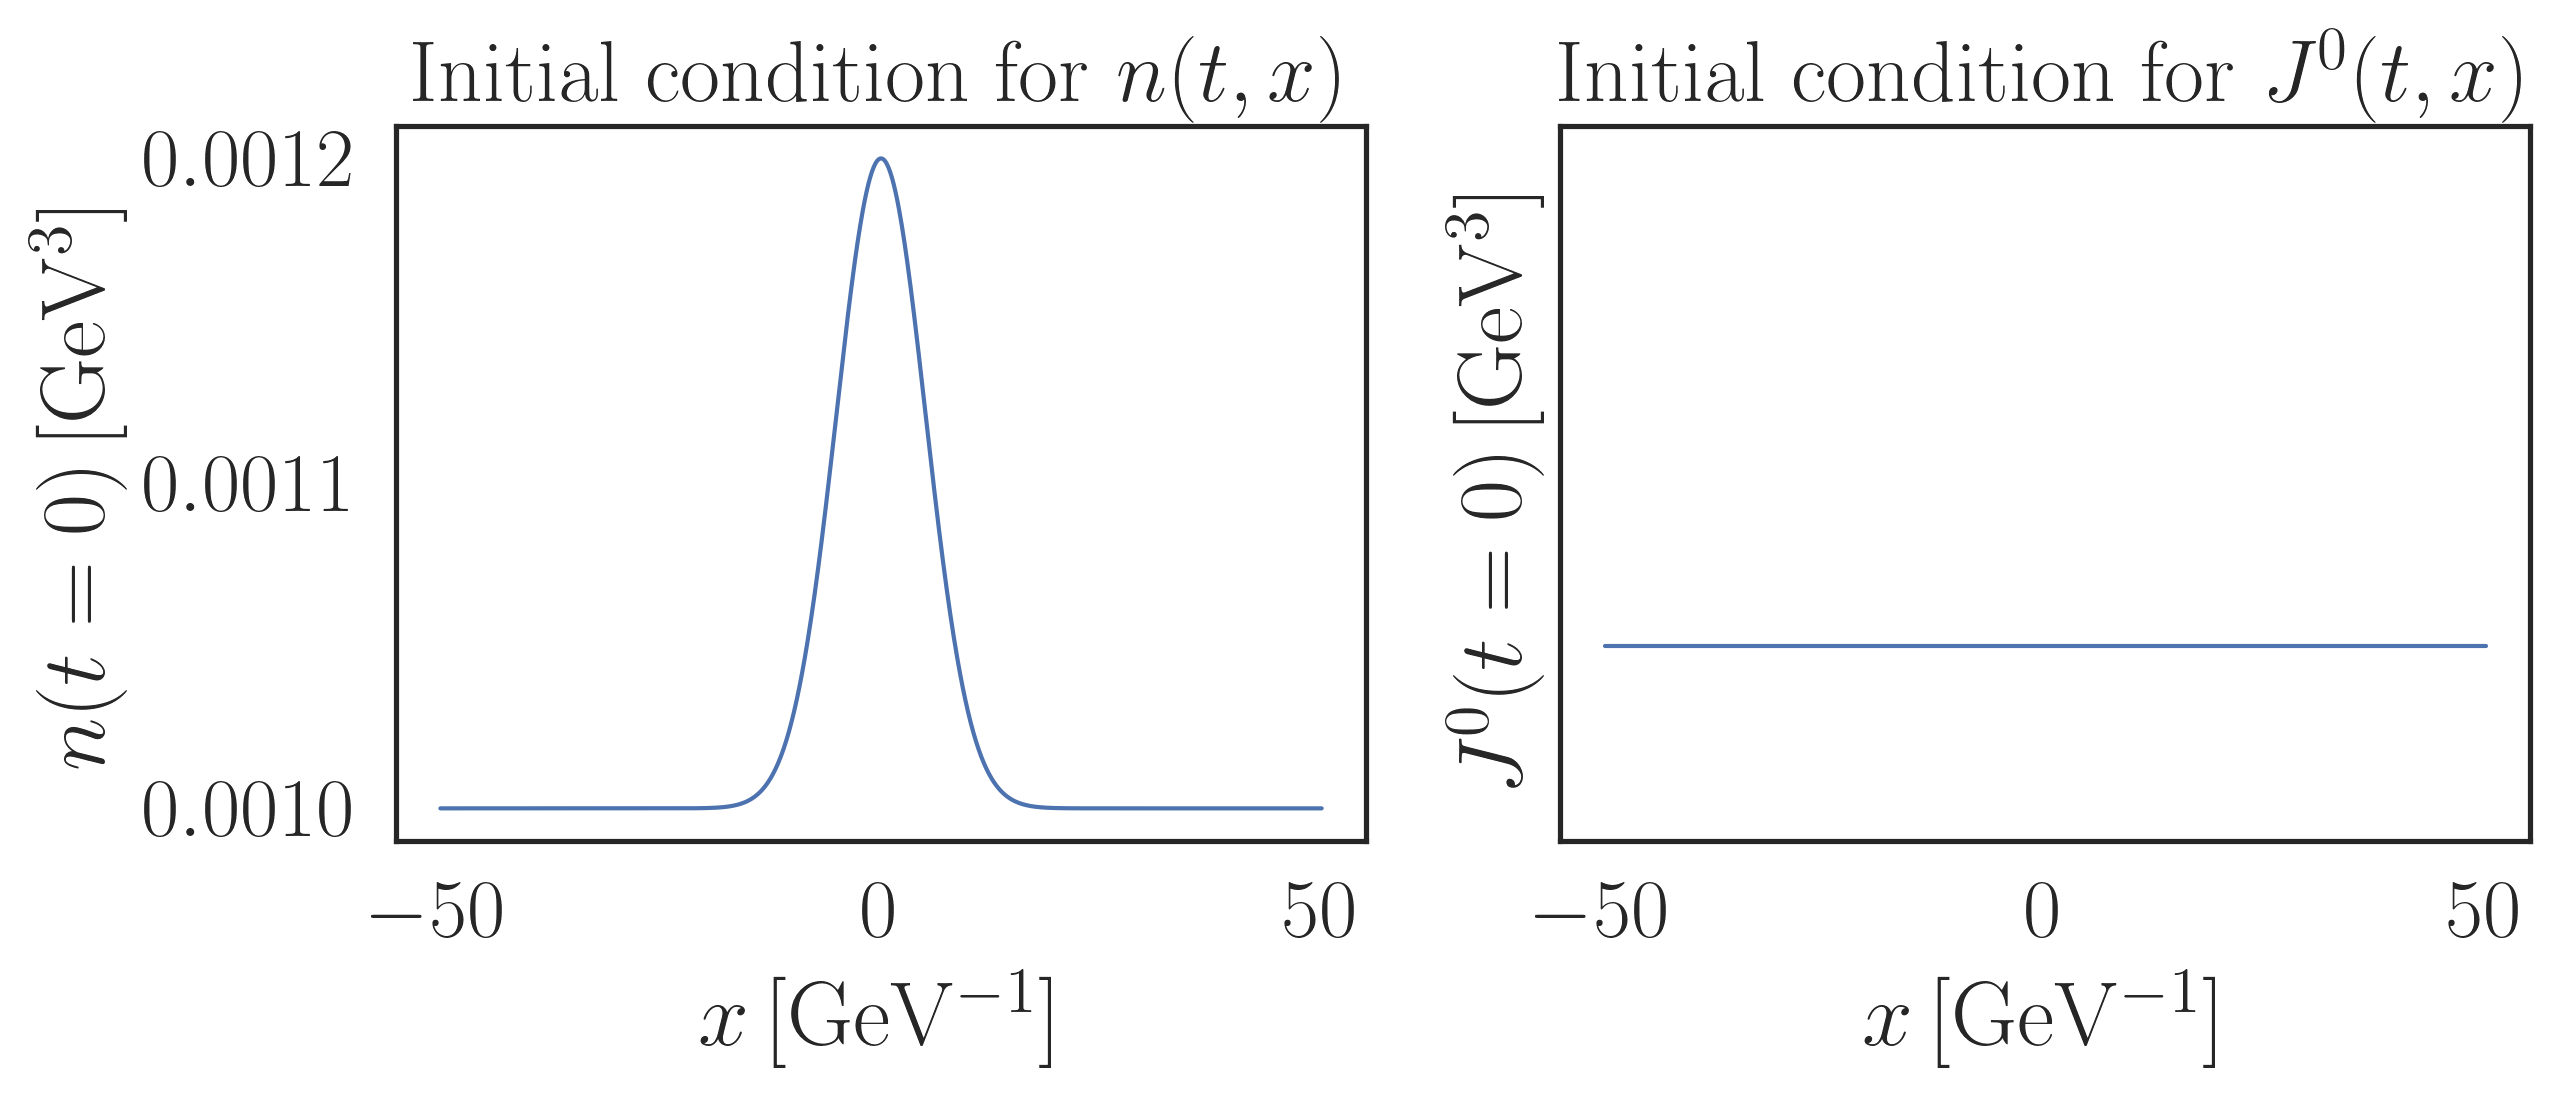

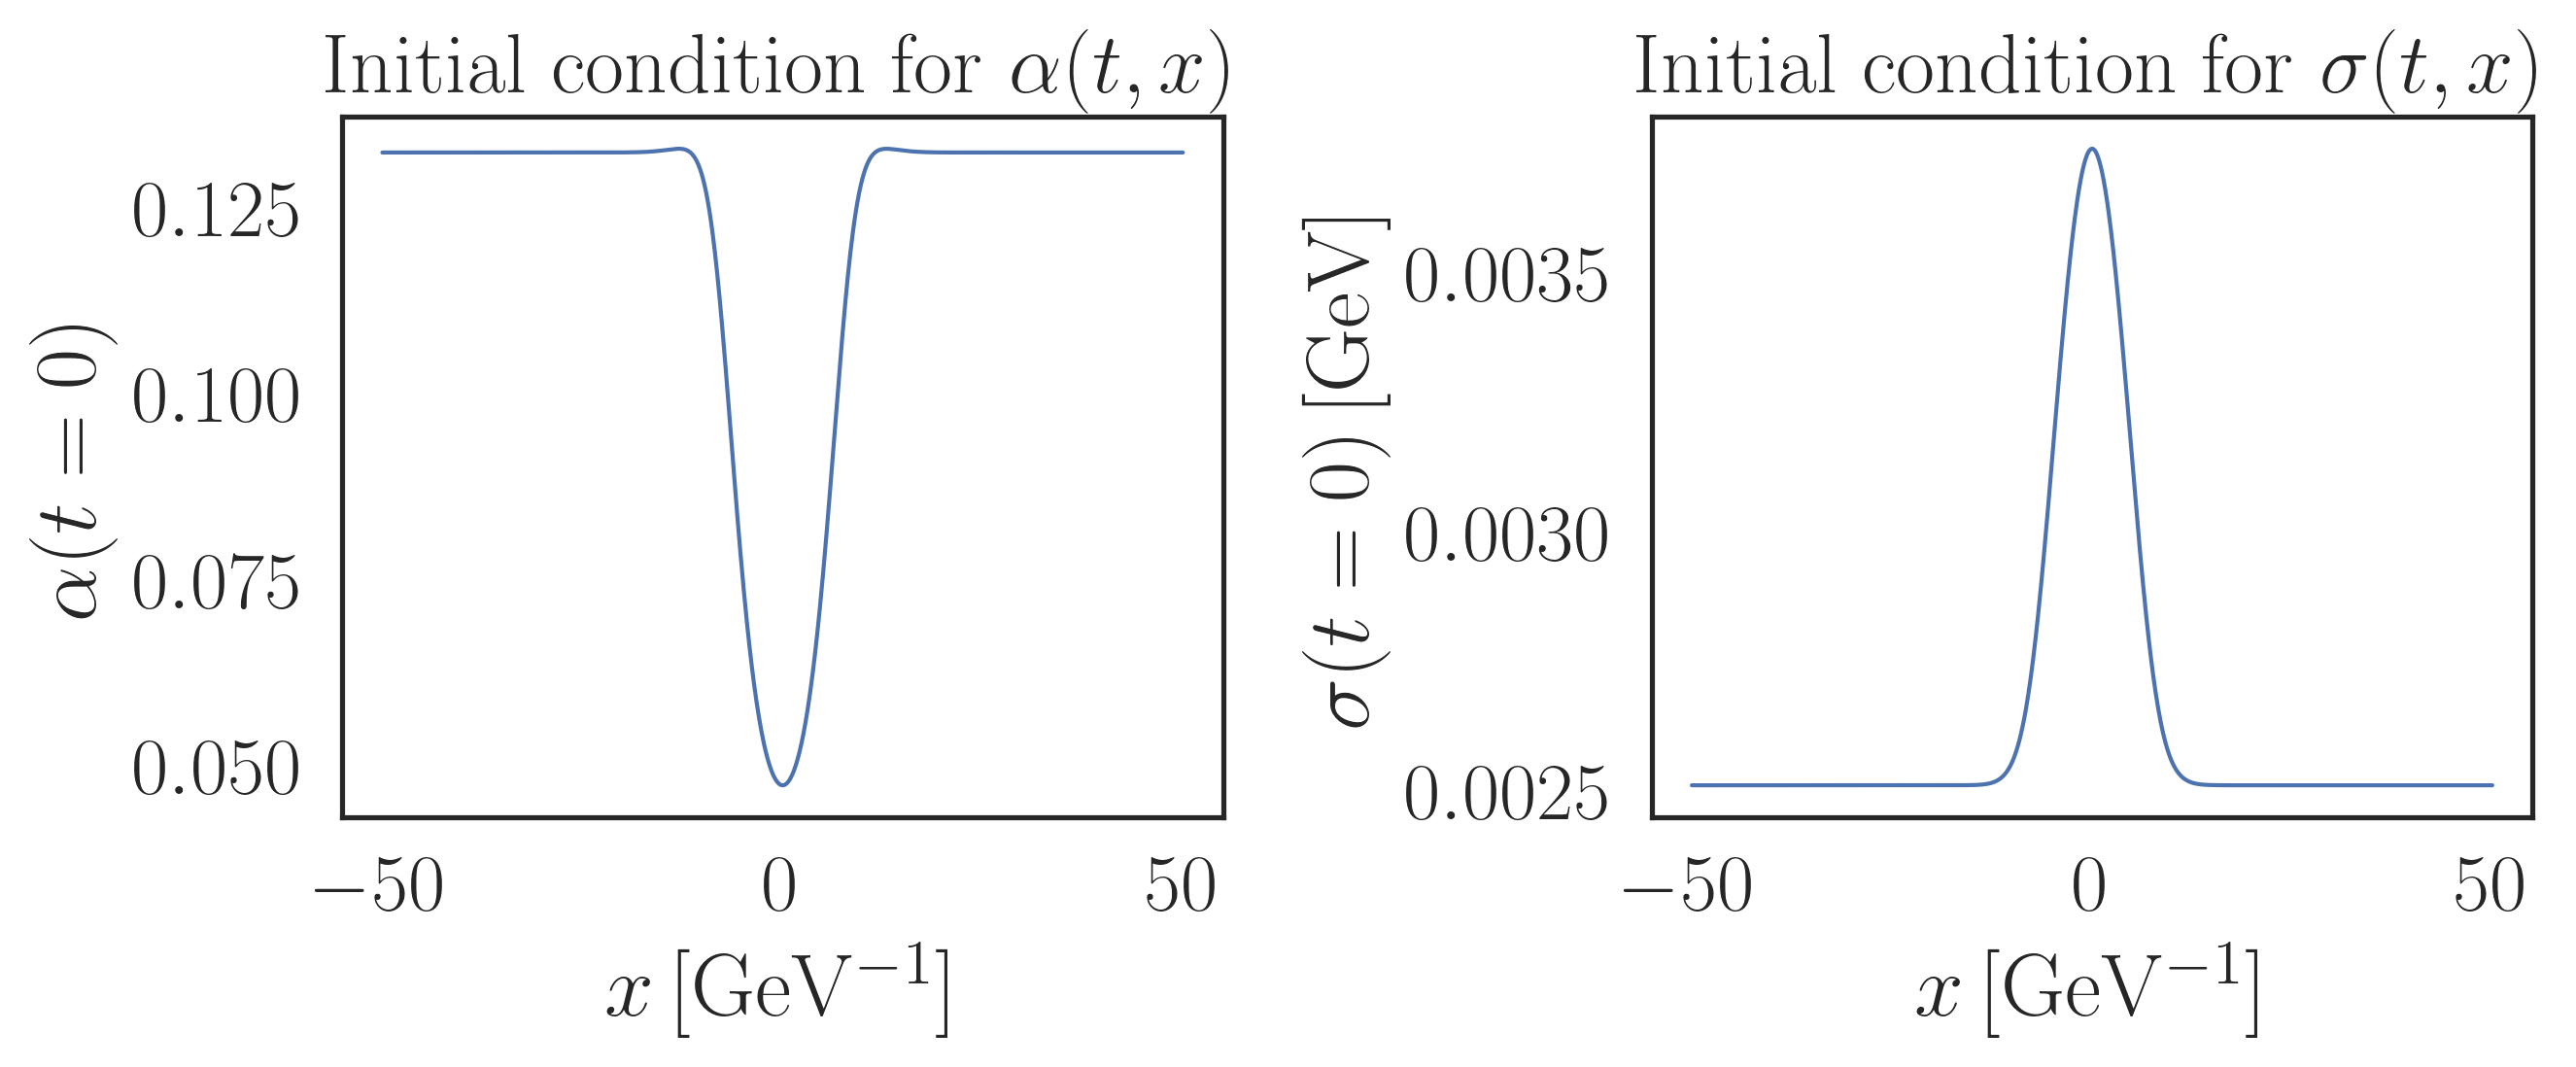

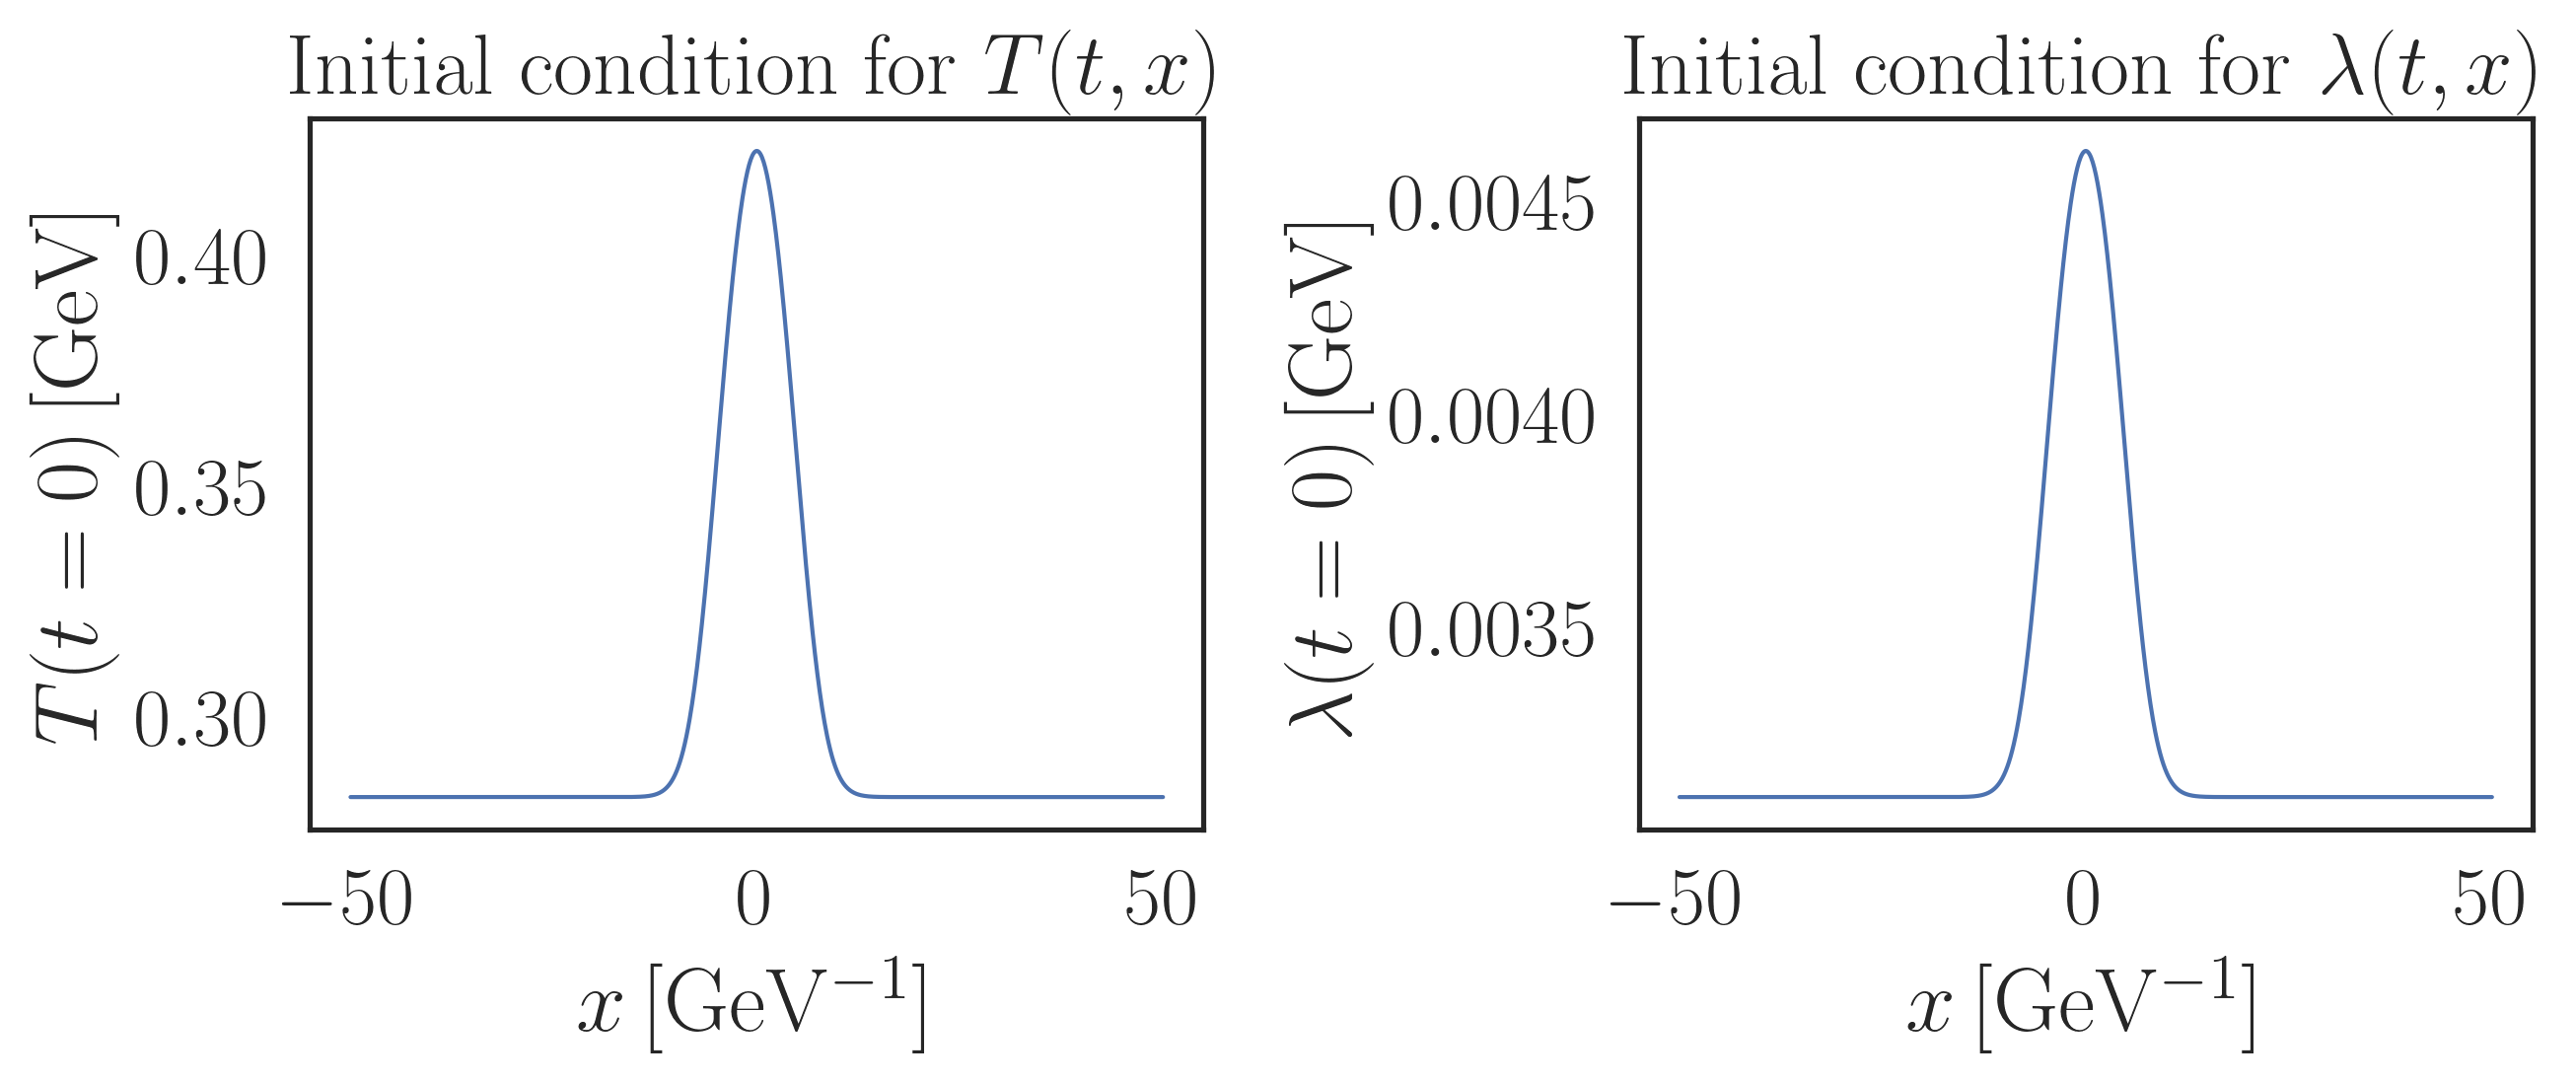

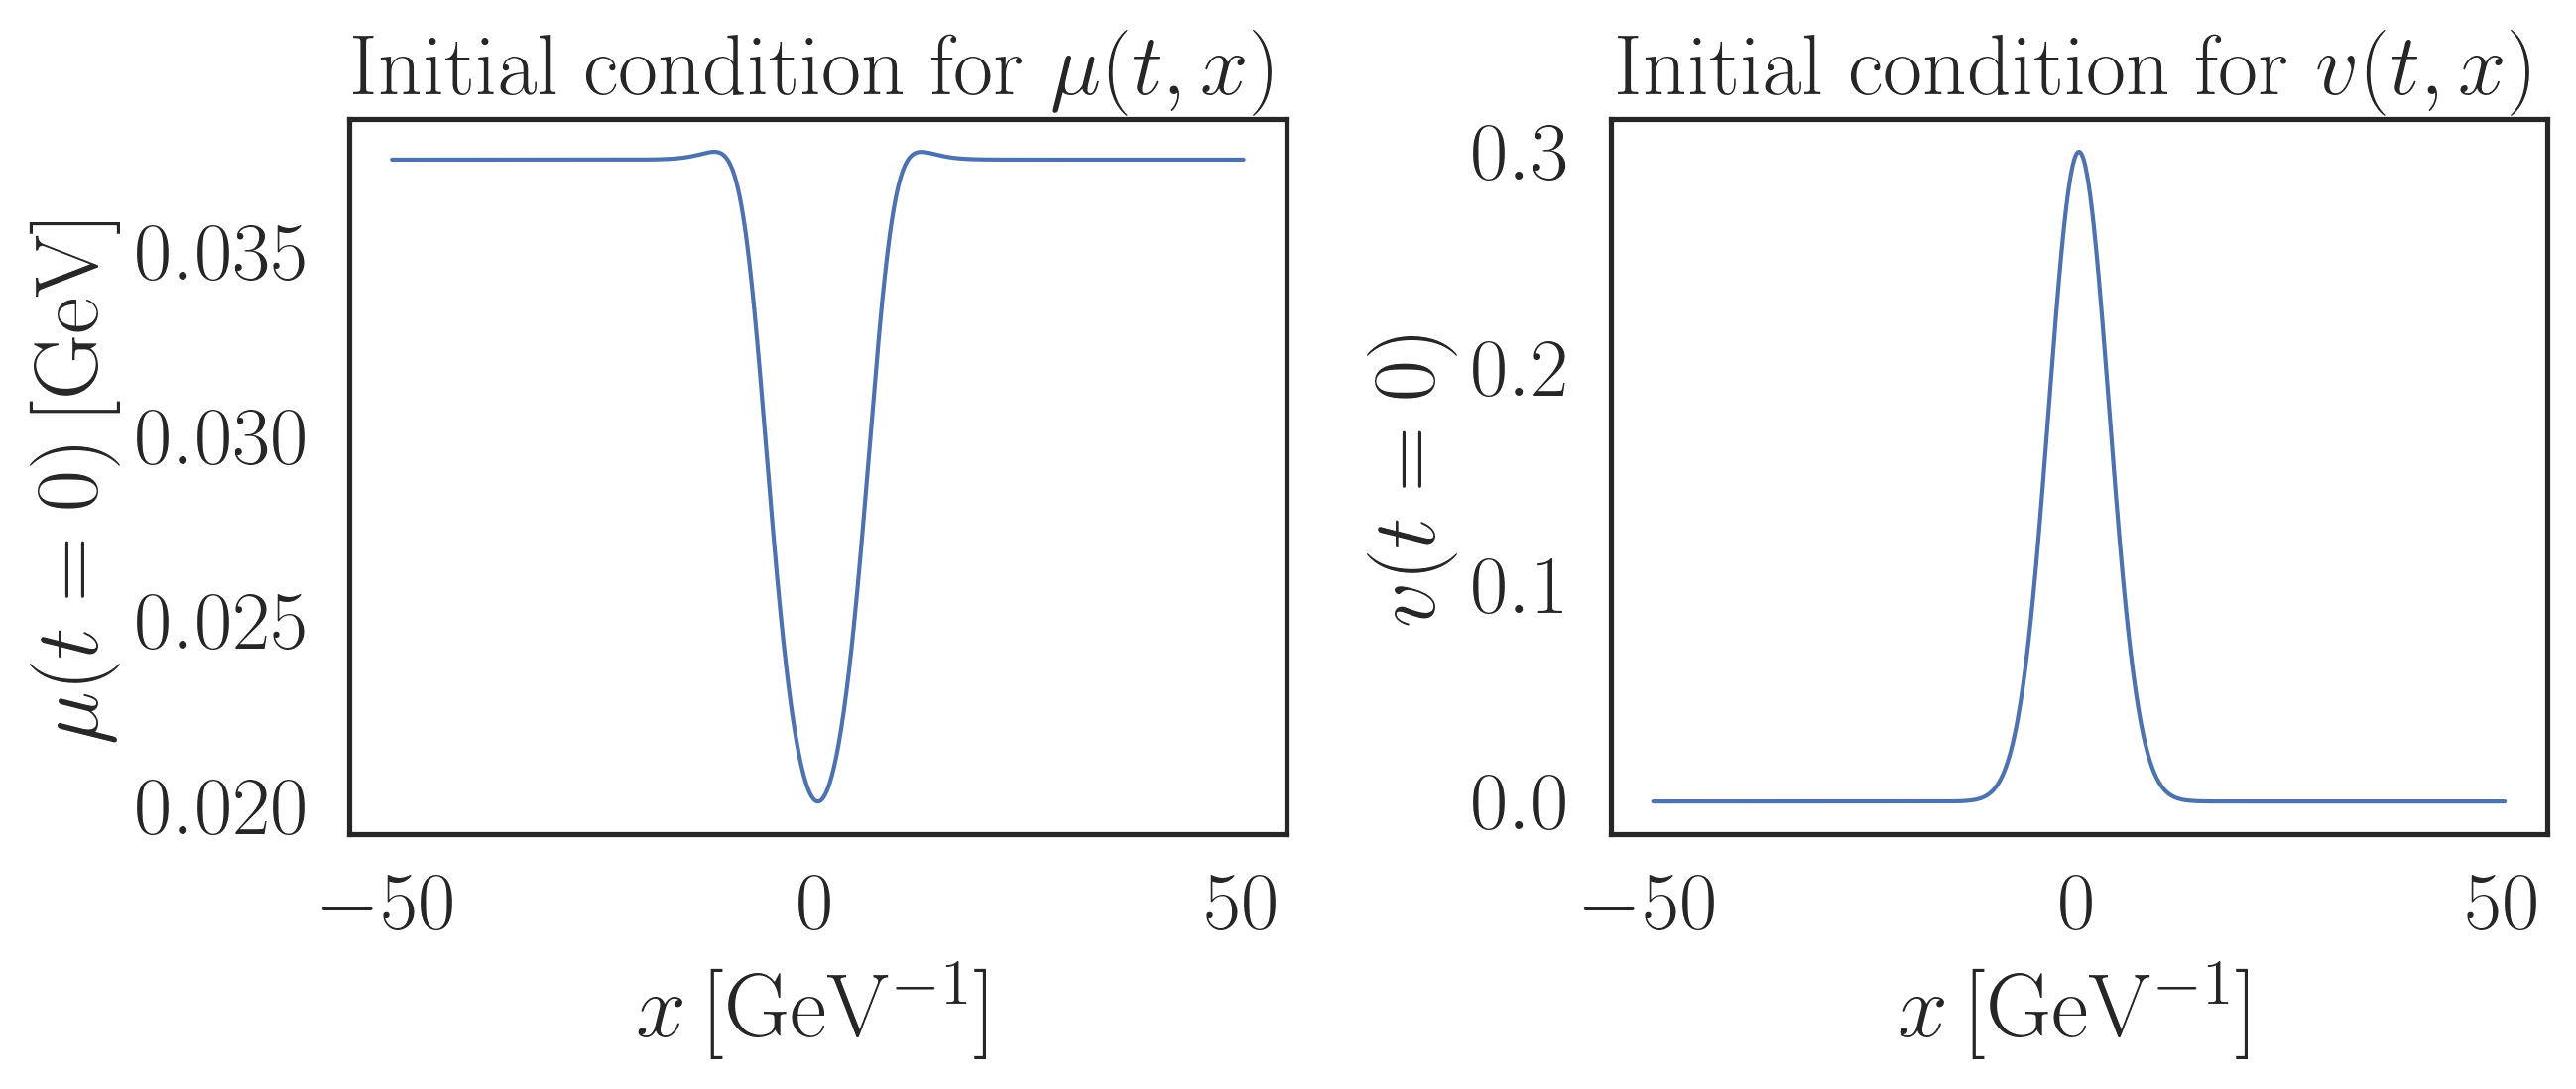

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['PATH'] = '/sw/apps/texlive/2024/bin/x86_64-linux:' + os.environ['PATH']

# Plotting style with seaborn
sns.set(style='white')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 18,
    'axes.titlesize': 21,
    'axes.labelsize': 22,
    'legend.fontsize': 22,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'font.serif': ['Computer Modern Roman'],
    'text.latex.preamble': r'\usepackage{amsmath}',
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# We print all key parameters
print("Domain, grid, and final simulation time:")
print(f"  L      = {L} GeV^-1         = {L/5.068:.3e} fm")
print(f"  Nx     = {Nx}")
print(f"  dx     = {dx:.3e} GeV^-1    = {dx/5.068:.3e} fm")
print(f"  t_end  = {t_end} GeV^-1          = {t_end*6.58e-25:3e} s")
print()

print("Initial-density parameters:")
print(f"  p = {p}, q = {q}, r = {r}")
print(f"  n(t=0,x):  min = {n_t0.min():.3e},  max = {n_t0.max():.3e}")
print(f"  α(t=0,x):  min = {alpha_t0.min():.3e},  max = {alpha_t0.max():.3e}")
print()

print("Initial-current parameters:")
print(f"  d = {d}, f = {f}, g = {g}")
print(f"  J⁰(t=0,x): min = {J0_t0.min():.3e},  max = {J0_t0.max():.3e}")
print(f"  Jˣ(t=0,x): min = {Jx_t0.min():.3e}, max = {Jx_t0.max():.3e}")
print()

print("Derived N-field:")
print(f"  N₀(t=0,x): min = {N_0_t0.min():.3e}, max = {N_0_t0.max():.3e}")

# Plot n(t=0) and J⁰(t=0)
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

axs[0].set_title(r'Initial condition for $n(t,x)$')
axs[0].plot(xc, n_t0, lw=1)
axs[0].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[0].set_ylabel(r'$n(t=0)\,{\rm [GeV^{3}]}$')

axs[1].set_title(r'Initial condition for $J^0(t,x)$')
axs[1].plot(xc, J0_t0, lw=1)
axs[1].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[1].set_ylabel(r'$J^0(t=0)\,{\rm [GeV^{3}]}$')

plt.tight_layout()
plt.show()

# Plot alpha(t=0) and sigma(t=0)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].set_title(r'Initial condition for $\alpha(t,x)$')
axs[0].plot(xc, alpha_t0, lw=1)
axs[0].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[0].set_ylabel(r'$\alpha(t=0)$')

axs[1].set_title(r'Initial condition for $\sigma(t,x)$')
axs[1].plot(xc, sigma_t0, lw=1)
axs[1].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[1].set_ylabel(r'$\sigma(t=0)\,{\rm [GeV]}$')

plt.tight_layout()
plt.show()

# Plot T(t=0) and lambda(t=0)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].set_title(r'Initial condition for $T(t,x)$')
axs[0].plot(xc, T_t0, lw=1)
axs[0].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[0].set_ylabel(r'$T(t=0)\,{\rm [GeV]}$')

axs[1].set_title(r'Initial condition for $\lambda(t,x)$')
axs[1].plot(xc, lambd_t0, lw=1)
axs[1].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[1].set_ylabel(r'$\lambda(t=0)\,{\rm [GeV]}$')

plt.tight_layout()
plt.show()

# Plot mu(t=0) and v(t=0)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].set_title(r'Initial condition for $\mu(t,x)$')
axs[0].plot(xc, mu_t0, lw=1)
axs[0].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[0].set_ylabel(r'$\mu(t=0)\,{\rm [GeV]}$')

axs[1].set_title(r'Initial condition for $v(t,x)$')
axs[1].plot(xc, v_t0, lw=1)
axs[1].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[1].set_ylabel(r'$v(t=0)$')

plt.tight_layout()
plt.show()

Everything looks good. We are good to go!

### Step 7

Here comes the most complicated part: implementing the Kurganov–Tadmor (KT) scheme and time-stepping our system, with dynamic time-step sizes and dynamic coefficients. For the BDNK diffusion model, the KT scheme would ask that we advance the solution by marching
$$
\partial_t
\begin{pmatrix}
J^0 \\
\alpha \\
N_x
\end{pmatrix}
+
\partial_x
\begin{pmatrix}
J^x \\
0   \\
-N_0
\end{pmatrix}
=
\begin{pmatrix}
0 \\
-\,N_0 \\
0
\end{pmatrix},
$$
using the central‐upwind method (*New High-Resolution Central Schemes for Nonlinear Conservation Laws and Convection–Diffusion Equations, pp. 252-256*). The pseudo‐algorithm is:

1. Let $\mathbf{U}$, given by $$\mathbf{U} = \begin{pmatrix} J^0 \\ \alpha \\ N_x\end{pmatrix},$$ denote the solution vector at each cell center.
2. While $t<t_{\rm end}$, repeat:
    1. From $\sigma(t,x)$ and $\lambda(t,x)$, compute the maximum local wave speed $c_{\rm max}(t)$, and use this to set the time step size $dt$ via the CFL condition.
    2. Advance the solution by one time step using the Kurganov–Tadmor scheme:
        1. Compute the local speeds $a^+$ and $a^-$ at each interface.
        2. Reconstruct the left/right states $\mathbf{U}_L$, $\mathbf{U}_R$ (piecewise-linear or CWENO).
        3. Compute the numerical flux $H_{i+1/2}$ at each interface.
        4. Form the source term $S = \begin{pmatrix} 0 \ -N_0 \ 0 \end{pmatrix}$.
        5. Update the solution: $$U_{\rm new} = U_{\rm old} − \frac{dt}{dx} (H_{i+1/2} − H_{i−1/2}) + dt \cdot S$$
    3. Update the coefficient fields:
        1. Using the new $\alpha(t,x)$, update $\sigma(t,x)$.
        2. Using the new $\sigma(t,x)$, update $\lambda(t,x)$.
    4. Advance time: $t \rightarrow t + dt$.

In [12]:
import time

@jit(nopython=True, cache=False)
def minmod(a, b):
    same = np.sign(a) == np.sign(b)
    mm = np.where(np.abs(a) < np.abs(b), a, b)
    return np.where(same, np.sign(a) * np.abs(mm), 0.0)

@jit(nopython=True, cache=False)
def mc(a, b):
    r = (a + 1e-16) / (b + 1e-16)
    phi = np.minimum(2.0 * r, np.minimum(0.5 * (1.0 + r), 2.0))
    return phi * b

@jit(nopython=True, cache=False)
def van_leer(a, b):
    r = (a + 1e-16) / (b + 1e-16)
    return (r + np.abs(r)) / (1.0 + np.abs(r)) * b

@jit(nopython=True, cache=False)
def reconstruct(U, dx):
    d_minus = U - roll2d_axis1(U, 1)
    d_plus  = roll2d_axis1(U, -1) - U
    slopes  = minmod(d_minus, d_plus) / dx
    slopes[1, :] = 0.0
    U_L = U - 0.5 * slopes * dx
    U_R = U + 0.5 * slopes * dx
    return U_L, U_R

@jit(nopython=True, cache=False)
def flux(U, sigma, T, lambd, v):
    J0_comp, alpha_comp, N_x_comp = U
    n_comp  = n_from_alpha_func(alpha_comp, T)
    N_0_comp = N_0_func(lambd, sigma, T, J0_comp, n_comp, N_x_comp, v)
    Jx = Jx_func(n_comp, sigma, lambd, T, N_x_comp, N_0_comp, v)
    return np.vstack((Jx,
                      np.zeros_like(Jx),
                      -N_0_comp))

@jit(nopython=True, cache=False)
def compute_local_speeds(U_L, U_R, sigma, lambd):
    c = np.sqrt(sigma / lambd)
    a_plus  =  c
    a_minus = -c
    return a_minus, a_plus

@jit(nopython=True, cache=False)
def extend_leftcol(A):
    m, n = A.shape
    out = np.empty((m, n + 1), A.dtype)
    out[:, :n] = A
    out[:, n] = A[:, 0]
    return out

@jit(nopython=True, cache=False)
def extend_rightcol(A):
    m, n = A.shape
    out = np.empty((m, n + 1), A.dtype)
    out[:, 0] = A[:, -1]
    out[:, 1:] = A
    return out

@jit(nopython=True, cache=False)
def iface_avg(cell):
    n = cell.size
    out = np.empty(n + 1, cell.dtype)
    out[0] = 0.5 * (cell[-1] + cell[0])
    for i in range(1, n):
        out[i] = 0.5 * (cell[i - 1] + cell[i])
    out[n] = 0.5 * (cell[-1] + cell[0])
    return out

@jit(nopython=True, cache=False)
def kt_step(U, dx, dt, sigma, T, lambd, v):
    U_Lc, U_Rc = reconstruct(U, dx)
    
    U_Li = extend_rightcol(U_Rc)
    U_Ri = extend_leftcol(U_Lc)
    
    sigma_iface = iface_avg(sigma)
    T_iface     = iface_avg(T)
    v_iface     = iface_avg(v)
    lambd_iface = iface_avg(lambd)
    
    a_minus, a_plus = compute_local_speeds(U_Li, U_Ri, sigma_iface, lambd_iface)
    
    F_L = flux(U_Li, sigma_iface, T_iface, lambd_iface, v_iface)
    F_R = flux(U_Ri, sigma_iface, T_iface, lambd_iface, v_iface)
    
    H = ( a_plus * F_L - a_minus * F_R
          + a_plus * a_minus * (U_Ri - U_Li)
        ) / (a_plus - a_minus)

    H[1, :] = 0.0
    
    S = np.zeros_like(U)
    alpha = U[1]
    n_comp = n_from_alpha_func(alpha, T)
    N_x = U[2]
    S[1] = -N_0_func(lambd, sigma, T, U[0], n_comp, N_x, v)
    
    dH = H[:, 1:] - H[:, :-1]
    U_new = U - (dt/dx) * dH + dt * S
    
    return U_new

@jit(nopython=True, cache=False)
def ssp_rk2(U, dx, dt, t, xc):
    T0 = T_func(t, xc)
    v0 = v_func(t, xc)
    a0 = U[1]
    s0 = sigma_func(a0, T0)
    l0 = lambd_func(s0)
    U1 = kt_step(U, dx, dt, s0, T0, l0, v0)

    t1 = t + dt
    T1 = T_func(t1, xc)
    v1 = v_func(t1, xc)
    a1 = U1[1]
    s1 = sigma_func(a1, T1)
    l1 = lambd_func(s1)
    U1_plus = kt_step(U1, dx, dt, s1, T1, l1, v1)
    
    U_new = 0.5*U + 0.5*U1_plus
    return U_new

U = np.vstack((J0_t0, alpha_t0, N_x_t0))
alpha = U[1]
T = T_t0
v = v_t0
sigma = sigma_t0
lambd = lambd_t0

c = np.sqrt(sigma / lambd)
c_max = np.max(c)
dt = dx / (8 * c_max)

U_hist = [U.copy()]
n_hist = [n_from_alpha_func(U[1], T)]
J0_hist = [U[0]]
t_hist = [t]

sigma_hist = [sigma.copy()]
T_hist     = [T.copy()]
v_hist     = [v.copy()]
lambd_hist = [lambd.copy()]
alpha_hist = [alpha.copy()]

Nx1start = time.time()
t_end_reached = False
while t < t_end:
    if t + dt > t_end:
        dt = t_end - t
        
    U = ssp_rk2(U, dx, dt, t, xc)
    
    t += dt
    
    T     = T_func(t, xc)
    v     = v_func(t, xc)
    alpha = U[1]
    sigma = sigma_func(alpha, T)
    lambd = lambd_func(sigma)
    
    c_max = np.max(np.sqrt(sigma / lambd))
    dt    = dx / (8 * c_max)
    
    U_hist.append(U.copy())
    n_hist.append(n_from_alpha_func(alpha, T))
    J0_hist.append(U[0].copy())

    alpha_hist.append(alpha.copy())
    sigma_hist.append(sigma.copy())
    lambd_hist.append(lambd.copy())
    T_hist.append(T.copy())
    v_hist.append(v.copy())
    t_hist.append(t)
Nx1end = time.time()

print(f"Successful run! Execution time: {Nx1end - Nx1start:.4f} seconds.")

Successful run! Execution time: 5.0451 seconds.


For the convergence test, we define a refinement ratio $r$ and construct two new $x$-resolutions `Nx2` and `Nx3` such that ${\rm Nx2}=r\cdot{\rm Nx}$ and ${\rm Nx3}=r\cdot{\rm Nx2}=r^2\cdot{\rm Nx}$. We then perform the same simulation at these resolutions and plot
$$
Q(t)=\log_{r}\!\left(\frac{\|\mathbf{q}(t,x;{\rm Nx})-\mathbf{q}(t,x;{\rm Nx2})\|_{1}}{\|\mathbf{q}(t,x;{\rm Nx2})-\mathbf{q}(t,x;{\rm Nx3})\|_{1}}\right),\quad\text{where}\quad \mathbf{q}=\{n,J^0\},
$$
where $\|\cdot\|_1$ is an $L_1$ norm computed on the shared coarse grid (after cell-averaging the higher-resolution data).

In [13]:
# First, we re-run in 2N and 4N resolution:

ratio = 2
Nx2 = Nx * ratio
Nx3 = Nx * ratio**2
assert Nx2 % Nx == 0 and Nx3 % Nx == 0

@jit(nopython=True, cache=False)
def run_same_core(Nx_val, t_targets):
    x_loc  = np.linspace(-L, L, Nx_val + 1)
    dx_loc = x_loc[1] - x_loc[0]
    xc_loc = 0.5 * (x_loc[:-1] + x_loc[1:])

    U_loc, T_loc, v_loc, sigma, lambd = make_IC(xc_loc, dx_loc, t=0.0)
    print(len(x_loc))

    t_loc = 0.0

    Nt_tar = t_targets.size
    t_arr     = np.empty(Nt_tar, dtype=np.float64)
    alpha_arr = np.empty((Nt_tar, Nx_val), dtype=np.float64)
    n_arr     = np.empty((Nt_tar, Nx_val), dtype=np.float64)
    J0_arr    = np.empty((Nt_tar, Nx_val), dtype=np.float64)

    t_arr[0]        = t_loc
    alpha_arr[0, :] = U_loc[1]
    n_arr[0, :]     = n_from_alpha_func(U_loc[1], T_loc)
    J0_arr[0, :]    = U_loc[0]

    k = 1
    tol = 1e-14

    while k < Nt_tar:
        c_max  = np.max(np.sqrt(sigma / lambd))
        dt_cfl = dx_loc / (8 * c_max)

        dt_to_target = t_targets[k] - t_loc
        dt_loc = dt_cfl if dt_cfl < dt_to_target else dt_to_target

        U_loc = ssp_rk2(U_loc, dx_loc, dt_loc, t_loc, xc_loc)
        t_loc += dt_loc

        T_loc = T_func(t_loc, xc_loc)
        v_loc = v_func(t_loc, xc_loc)
        alpha_loc = U_loc[1]
        sigma = sigma_func(alpha_loc, T_loc)
        lambd = lambd_func(sigma)

        if t_loc >= (t_targets[k] - tol):
            t_arr[k]        = t_loc
            alpha_arr[k, :] = alpha_loc
            n_arr[k, :]     = n_from_alpha_func(alpha_loc, T_loc)
            J0_arr[k, :]    = U_loc[0]
            k += 1

    return t_arr, xc_loc, dx_loc, alpha_arr, n_arr, J0_arr

def run_same(Nx_val, t_targets):
    t_arr, xc_loc, dx_loc, alpha_arr, n_arr, J0_arr = run_same_core(Nx_val, t_targets)
    return {
        "t":     t_arr,
        "xc":    xc_loc,
        "dx":    dx_loc,
        "alpha": alpha_arr,
        "n":     n_arr,
        "J0":    J0_arr,
    }

t_base      = np.array(t_hist)
xc_base     = np.array(xc)
dx_base     = xc_base[1] - xc_base[0]
alpha_base  = np.array(alpha_hist)
J0_base     = np.array(J0_hist)
n_base      = np.array(n_hist)

t_targets = t_base

res2start = time.time()
res2 = run_same(Nx2, t_targets)
res2end = time.time()
print(f"Successful run for Nx2! Execution time: {res2end - res2start:.4f} seconds.")

res3start = time.time()
res3 = run_same(Nx3, t_targets)
res3end = time.time()
print(f"Successful run for Nx3! Execution time: {res3end - res3start:.4f} seconds.")


# With these results, we now perform the convergence test:

Nt = len(t_base)
assert np.allclose(res2["t"], t_base) and np.allclose(res3["t"], t_base)

def restrict_space_cellavg(arr_t_x, R):
    Nt_local, Nx_f = arr_t_x.shape
    assert Nx_f % R == 0
    return arr_t_x.reshape(Nt_local, Nx_f // R, R).mean(axis=2)

n2_on_coarse  = restrict_space_cellavg(res2["n"],  ratio)
n3_on_coarse  = restrict_space_cellavg(res3["n"],  ratio*ratio)

n_base_coarse  = n_base

Nx_base = n_base_coarse.shape[1]
j_lo, j_hi = 0, Nx_base

@jit(nopython=True, cache=False)
def l1_norm_timewise_interior(diff, dx, j_lo, j_hi):
    Nt_loc, Nx_loc = diff.shape
    out = np.empty(Nt_loc, dtype=diff.dtype)
    for it in range(Nt_loc):
        acc = 0.0
        for j in range(j_lo, j_hi):
            acc += abs(diff[it, j])
        out[it] = dx * acc
    return out

@jit(nopython=True, cache=False)
def eoc_safe(norm12, norm23, ratio, tiny=1e-300):
    N = norm12.shape[0]
    out = np.empty(N, dtype=np.float64)
    logR = np.log(ratio)
    for i in range(N):
        n12 = norm12[i]
        n23 = norm23[i]
        if np.isfinite(n12) and np.isfinite(n23) and (n12 > tiny) and (n23 > tiny):
            out[i] = np.log(n12 / n23) / logR
        else:
            out[i] = np.nan
    return out

diff12_n  = n_base_coarse  - n2_on_coarse
diff23_n  = n2_on_coarse   - n3_on_coarse
norm12_n  = l1_norm_timewise_interior(diff12_n,  dx_base, j_lo, j_hi)
norm23_n  = l1_norm_timewise_interior(diff23_n,  dx_base, j_lo, j_hi)
Q_n_L1    = eoc_safe(norm12_n, norm23_n, ratio)

t_Q = t_base

2001
Successful run for Nx2! Execution time: 2.5856 seconds.
4001
Successful run for Nx3! Execution time: 5.4923 seconds.


### Step 8

Once the time-stepping is complete, we analyze the evolution of the system by visualizing several key quantities. We plot the density $n(t, x)$ and current $J^0(t, x)$ both as snapshots at selected times and as spacetime colormaps. We also check the degree to which the numerical solution satisfies the underlying PDE by plotting the relevant combinations of time and space derivatives, as well as the residuals of the key equations. This visualization stage provides a comprehensive look at the simulation output and helps assess the accuracy and behavior of the method. Let's first save the data:

In [14]:
# Save KT.npz with J0(t,x), alpha(t,x), T(t,x), t, x, and v for all three resolutions

# N
J0_Nx    = np.stack(J0_hist, axis=0)
alpha_Nx = np.stack(alpha_hist, axis=0)
T_Nx     = np.stack(T_hist, axis=0)
v_Nx     = np.stack(v_hist, axis=0)
t_Nx     = np.array(t_hist)
x_Nx     = np.array(xc)

# 2N
t_Nx2  = res2["t"]
x_Nx2  = res2["xc"]
J0_Nx2 = res2["J0"]
alpha_Nx2 = res2["alpha"]
T_Nx2  = np.stack([T_func(tt, x_Nx2) for tt in t_Nx2], axis=0)
v_Nx2  = np.stack([v_func(tt, x_Nx2) for tt in t_Nx2], axis=0)

# 4N
t_Nx3  = res3["t"]
x_Nx3  = res3["xc"]
J0_Nx3 = res3["J0"]
alpha_Nx3 = res3["alpha"]
T_Nx3  = np.stack([T_func(tt, x_Nx3) for tt in t_Nx3], axis=0)
v_Nx3  = np.stack([v_func(tt, x_Nx3) for tt in t_Nx3], axis=0)

np.savez("KT.npz",
         J0_Nx=J0_Nx, alpha_Nx=alpha_Nx, T_Nx=T_Nx, v_Nx=v_Nx, t_Nx=t_Nx, x_Nx=x_Nx,
         J0_Nx2=J0_Nx2, alpha_Nx2=alpha_Nx2, T_Nx2=T_Nx2, v_Nx2=v_Nx2, t_Nx2=t_Nx2, x_Nx2=x_Nx2,
         J0_Nx3=J0_Nx3, alpha_Nx3=alpha_Nx3, T_Nx3=T_Nx3, v_Nx3=v_Nx3, t_Nx3=t_Nx3, x_Nx3=x_Nx3)

print("Saved KT.npz with J0, alpha, T, v, t, x for Nx, Nx2, Nx3")

Saved KT.npz with J0, alpha, T, v, t, x for Nx, Nx2, Nx3


And let's now plot:

/var/folders/99/d57ws21n5zl11v6rbkbknpqm0000gn/T/ipykernel_30385/2440956374.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greys_r", 256)


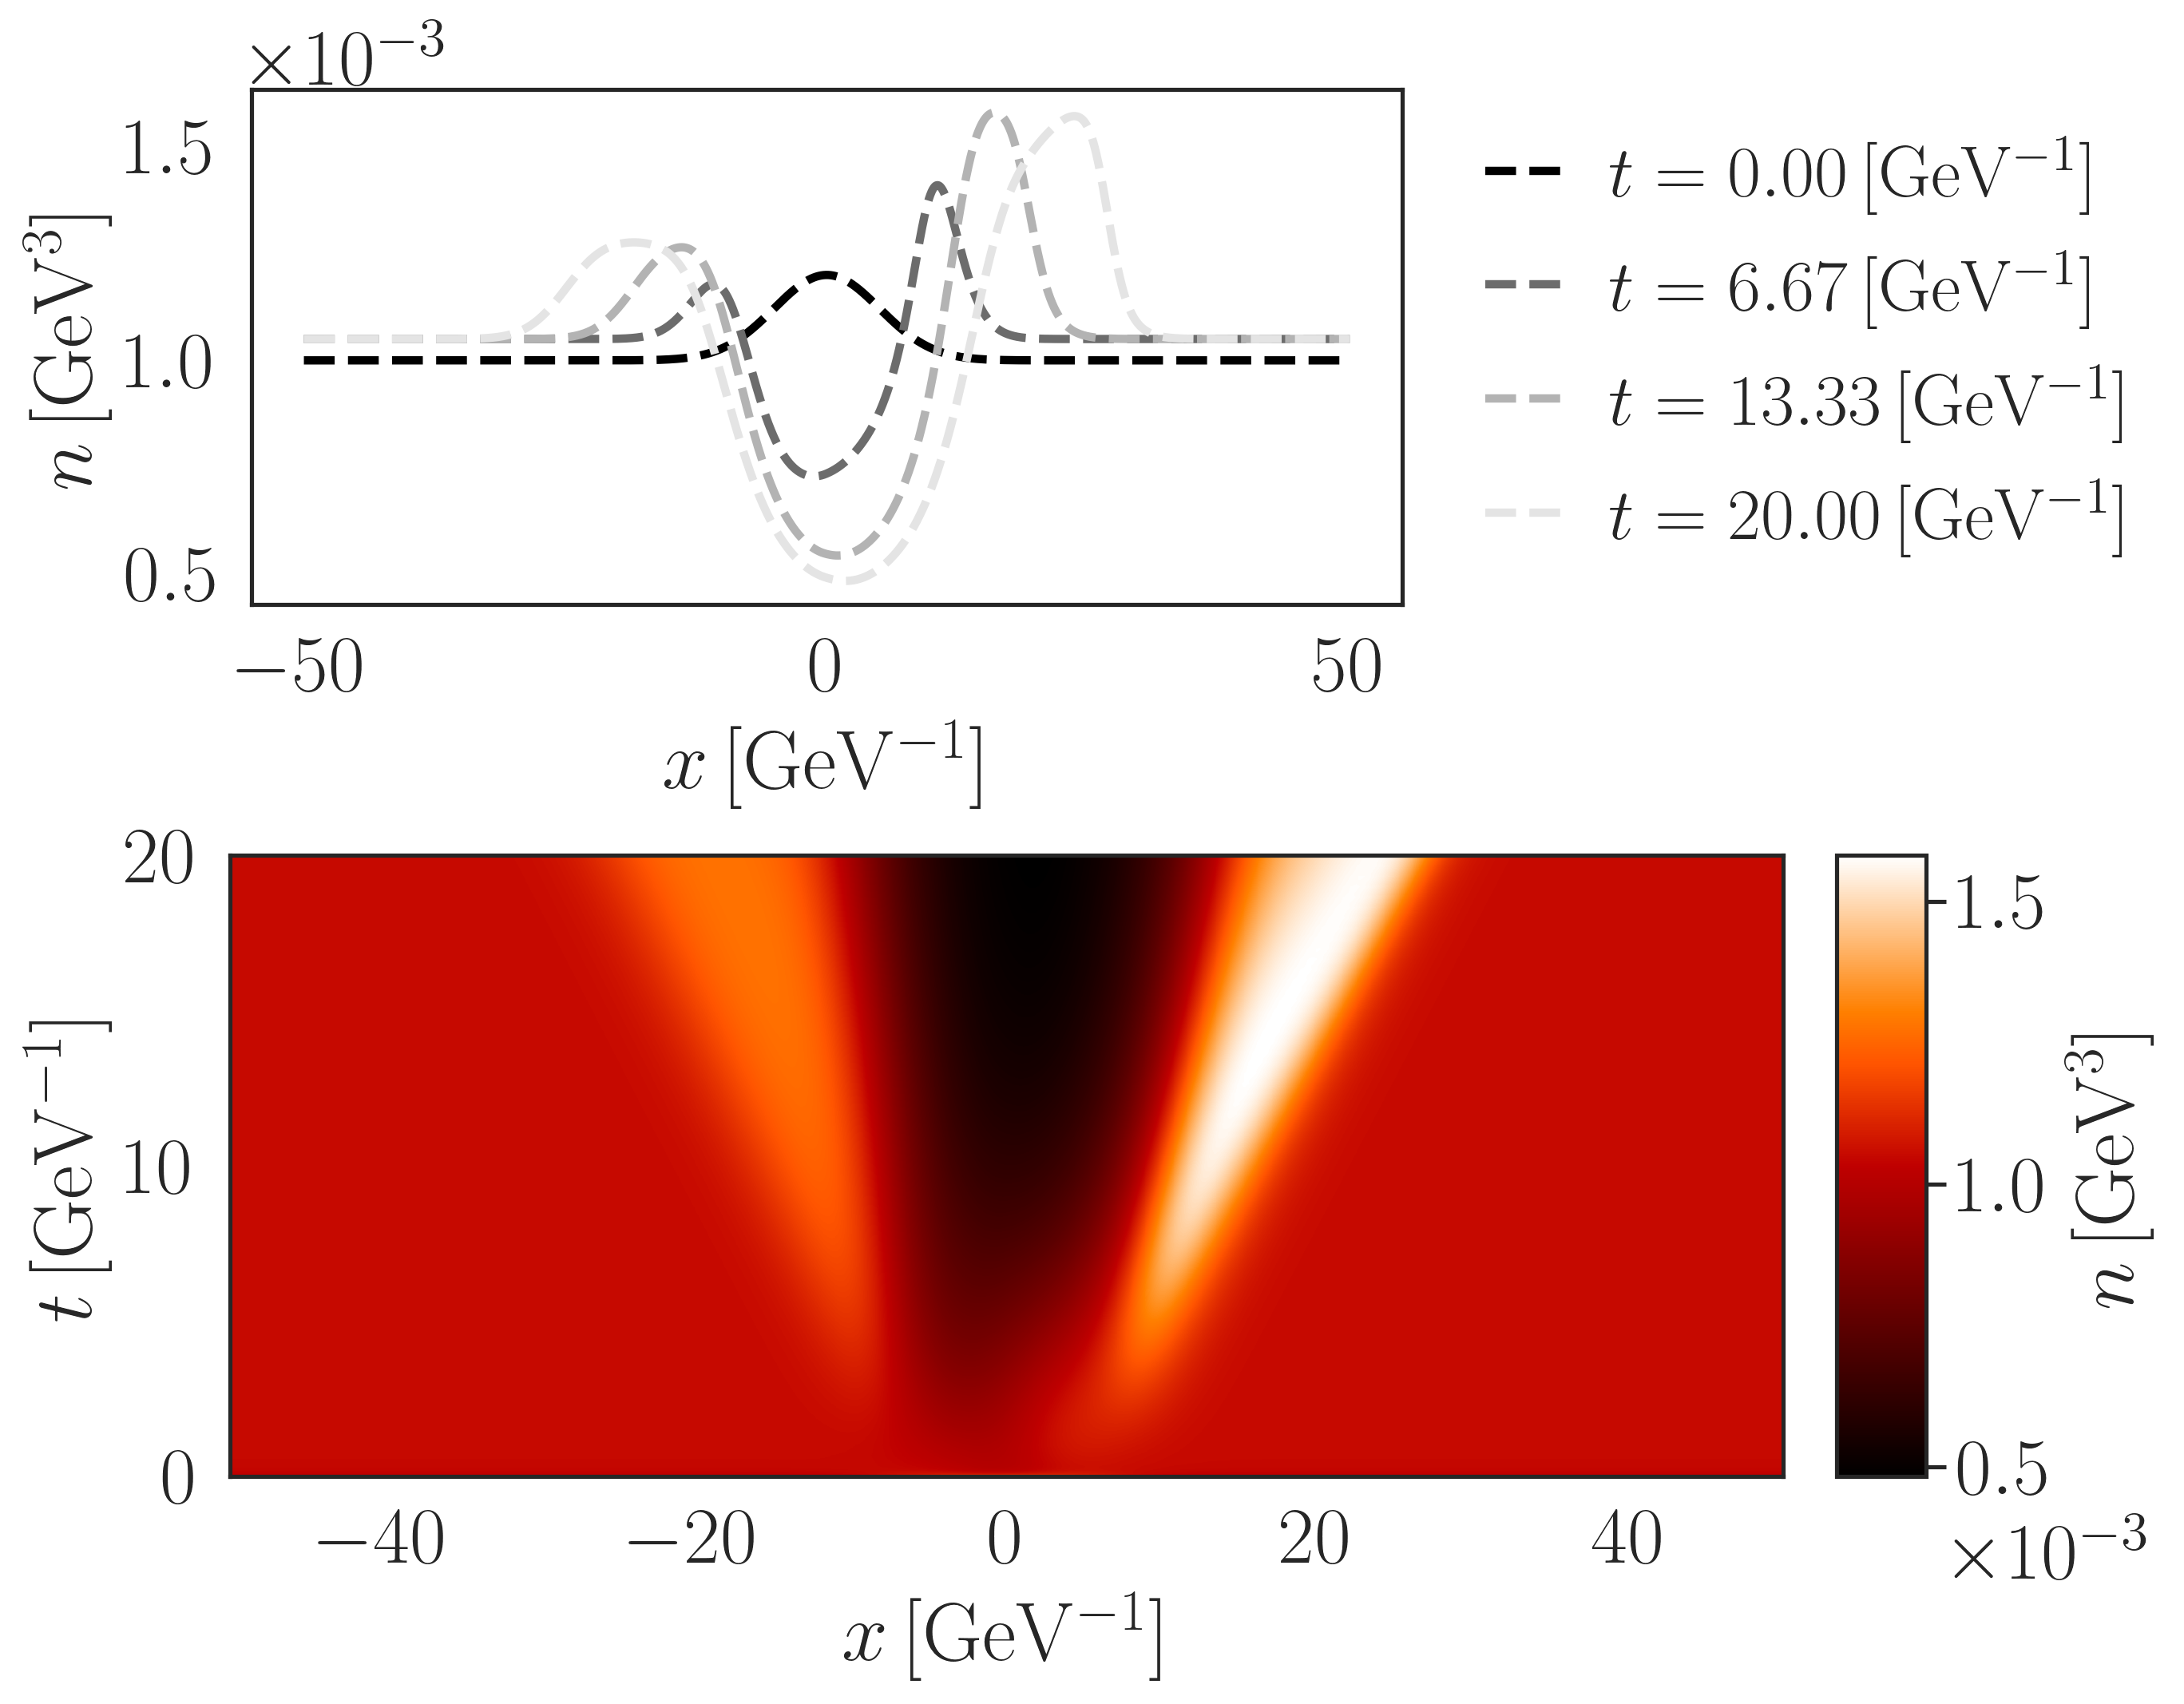

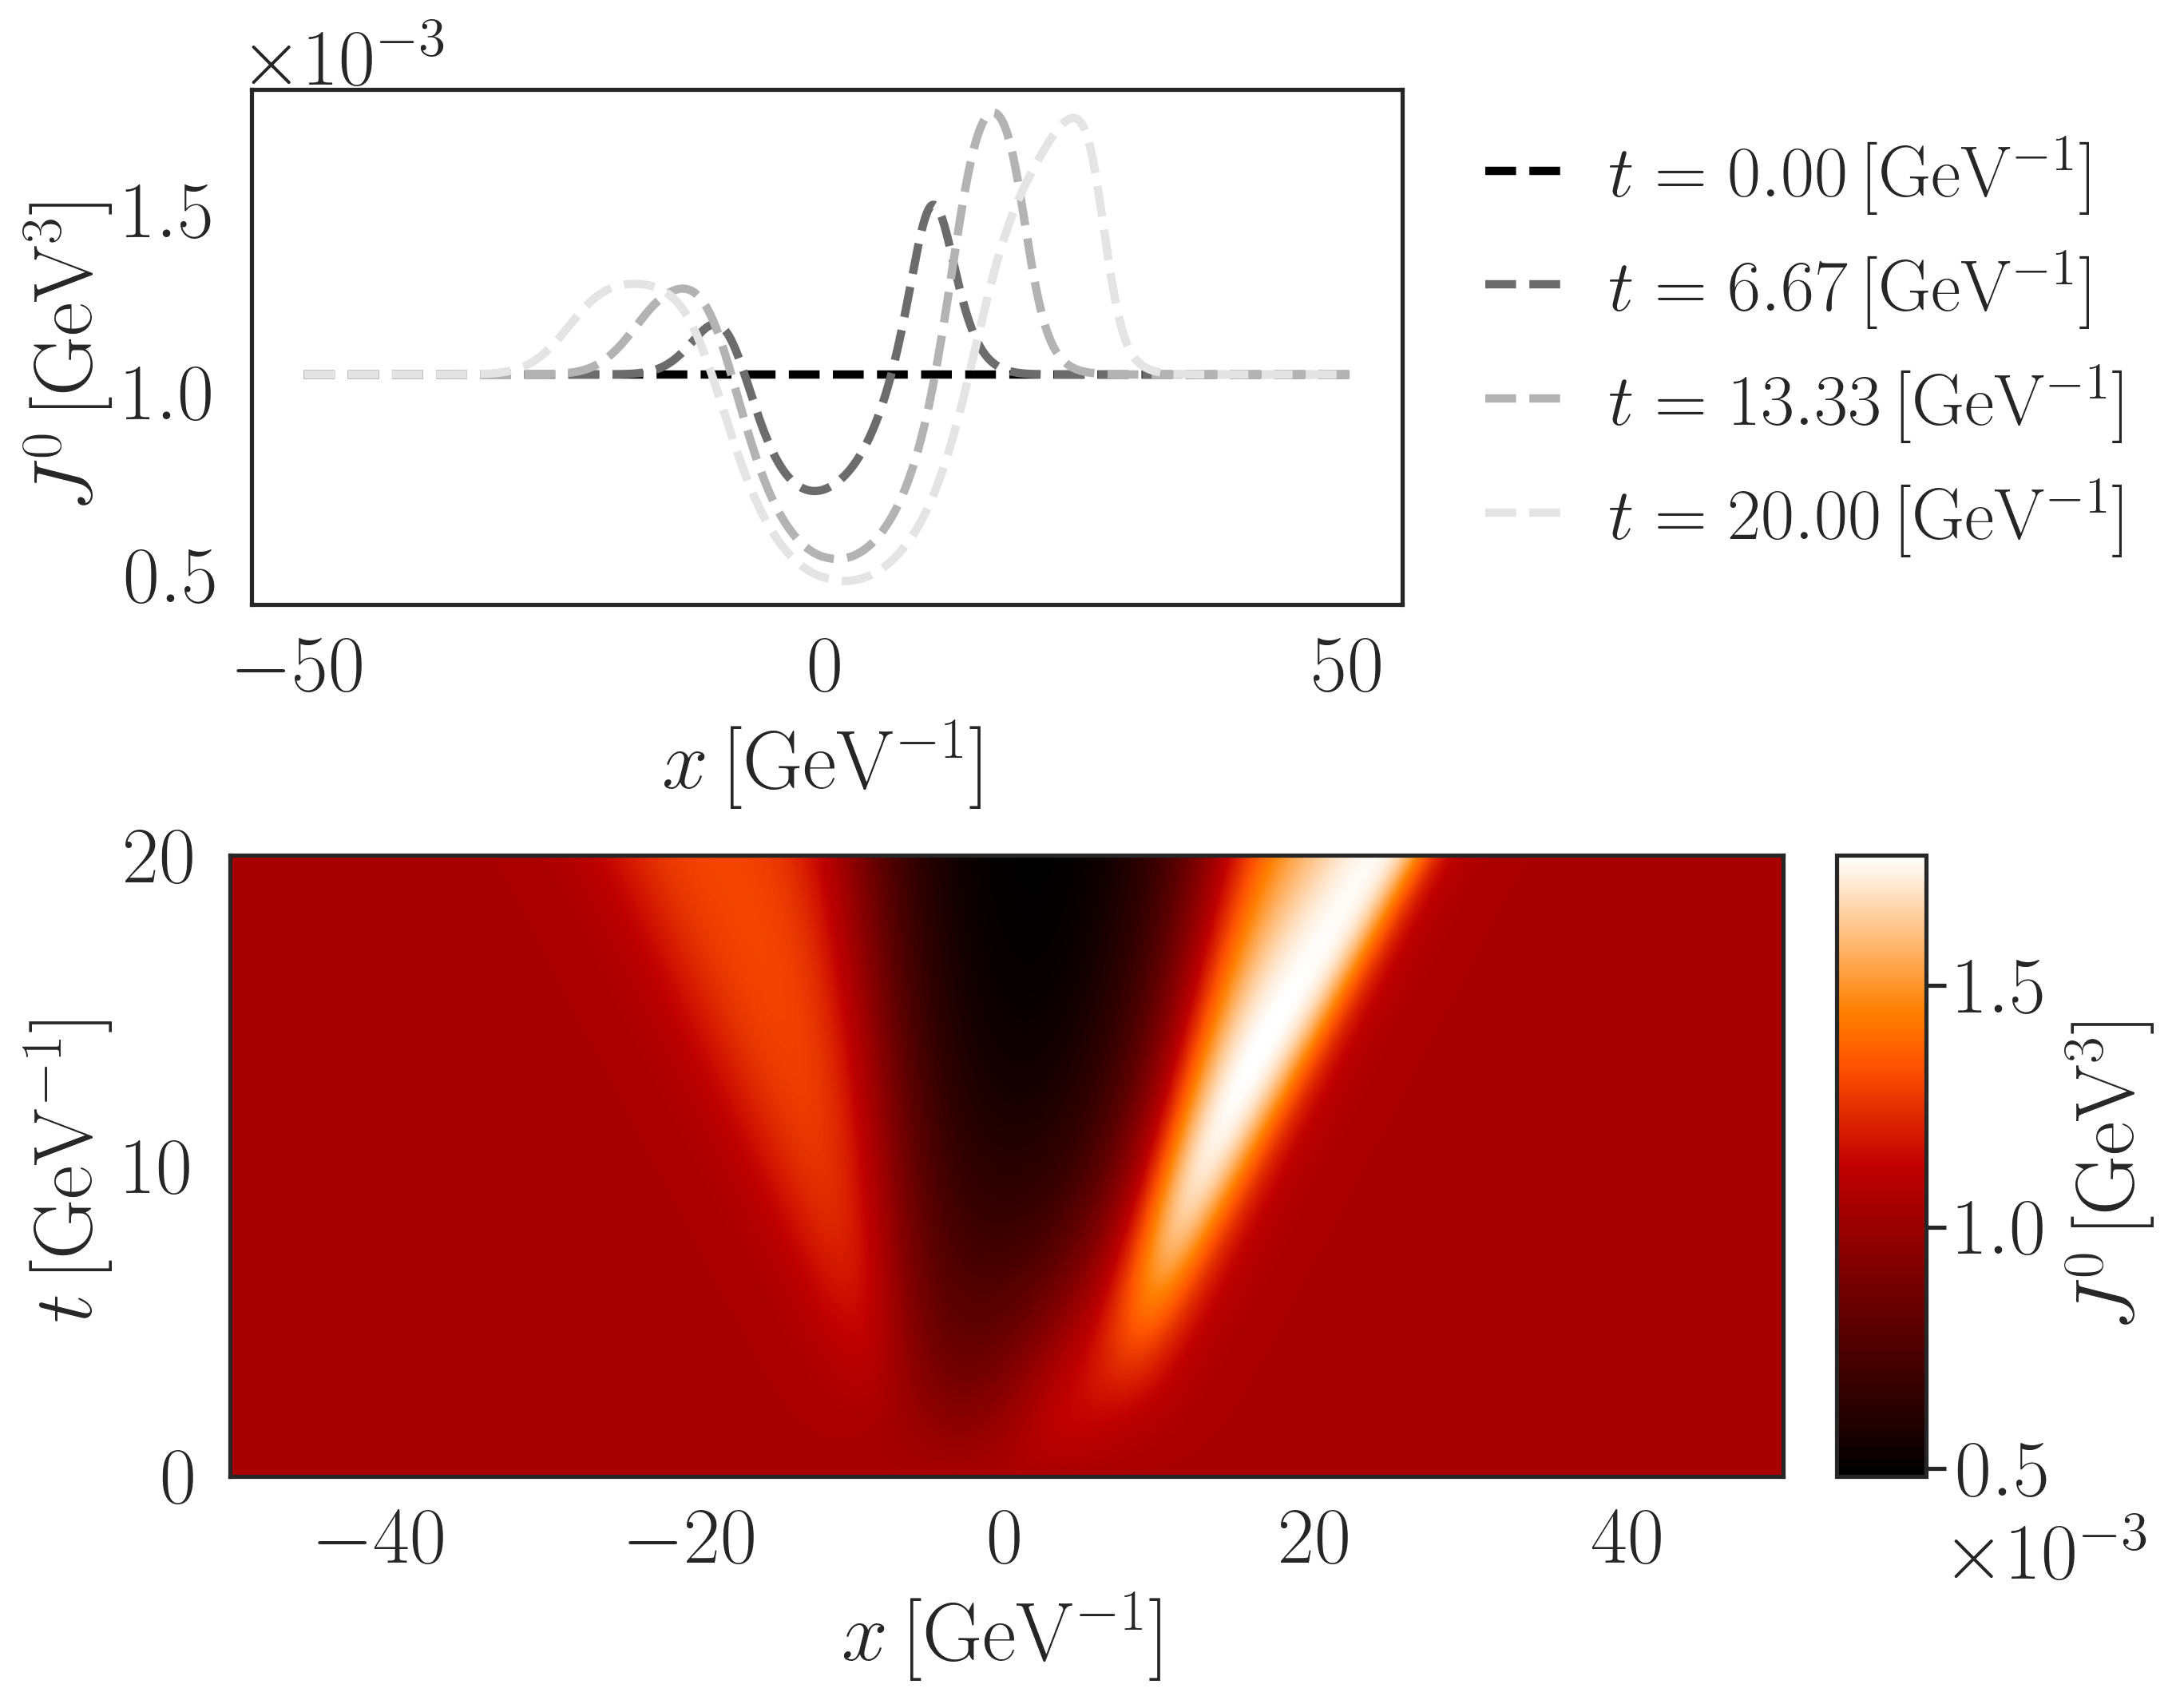

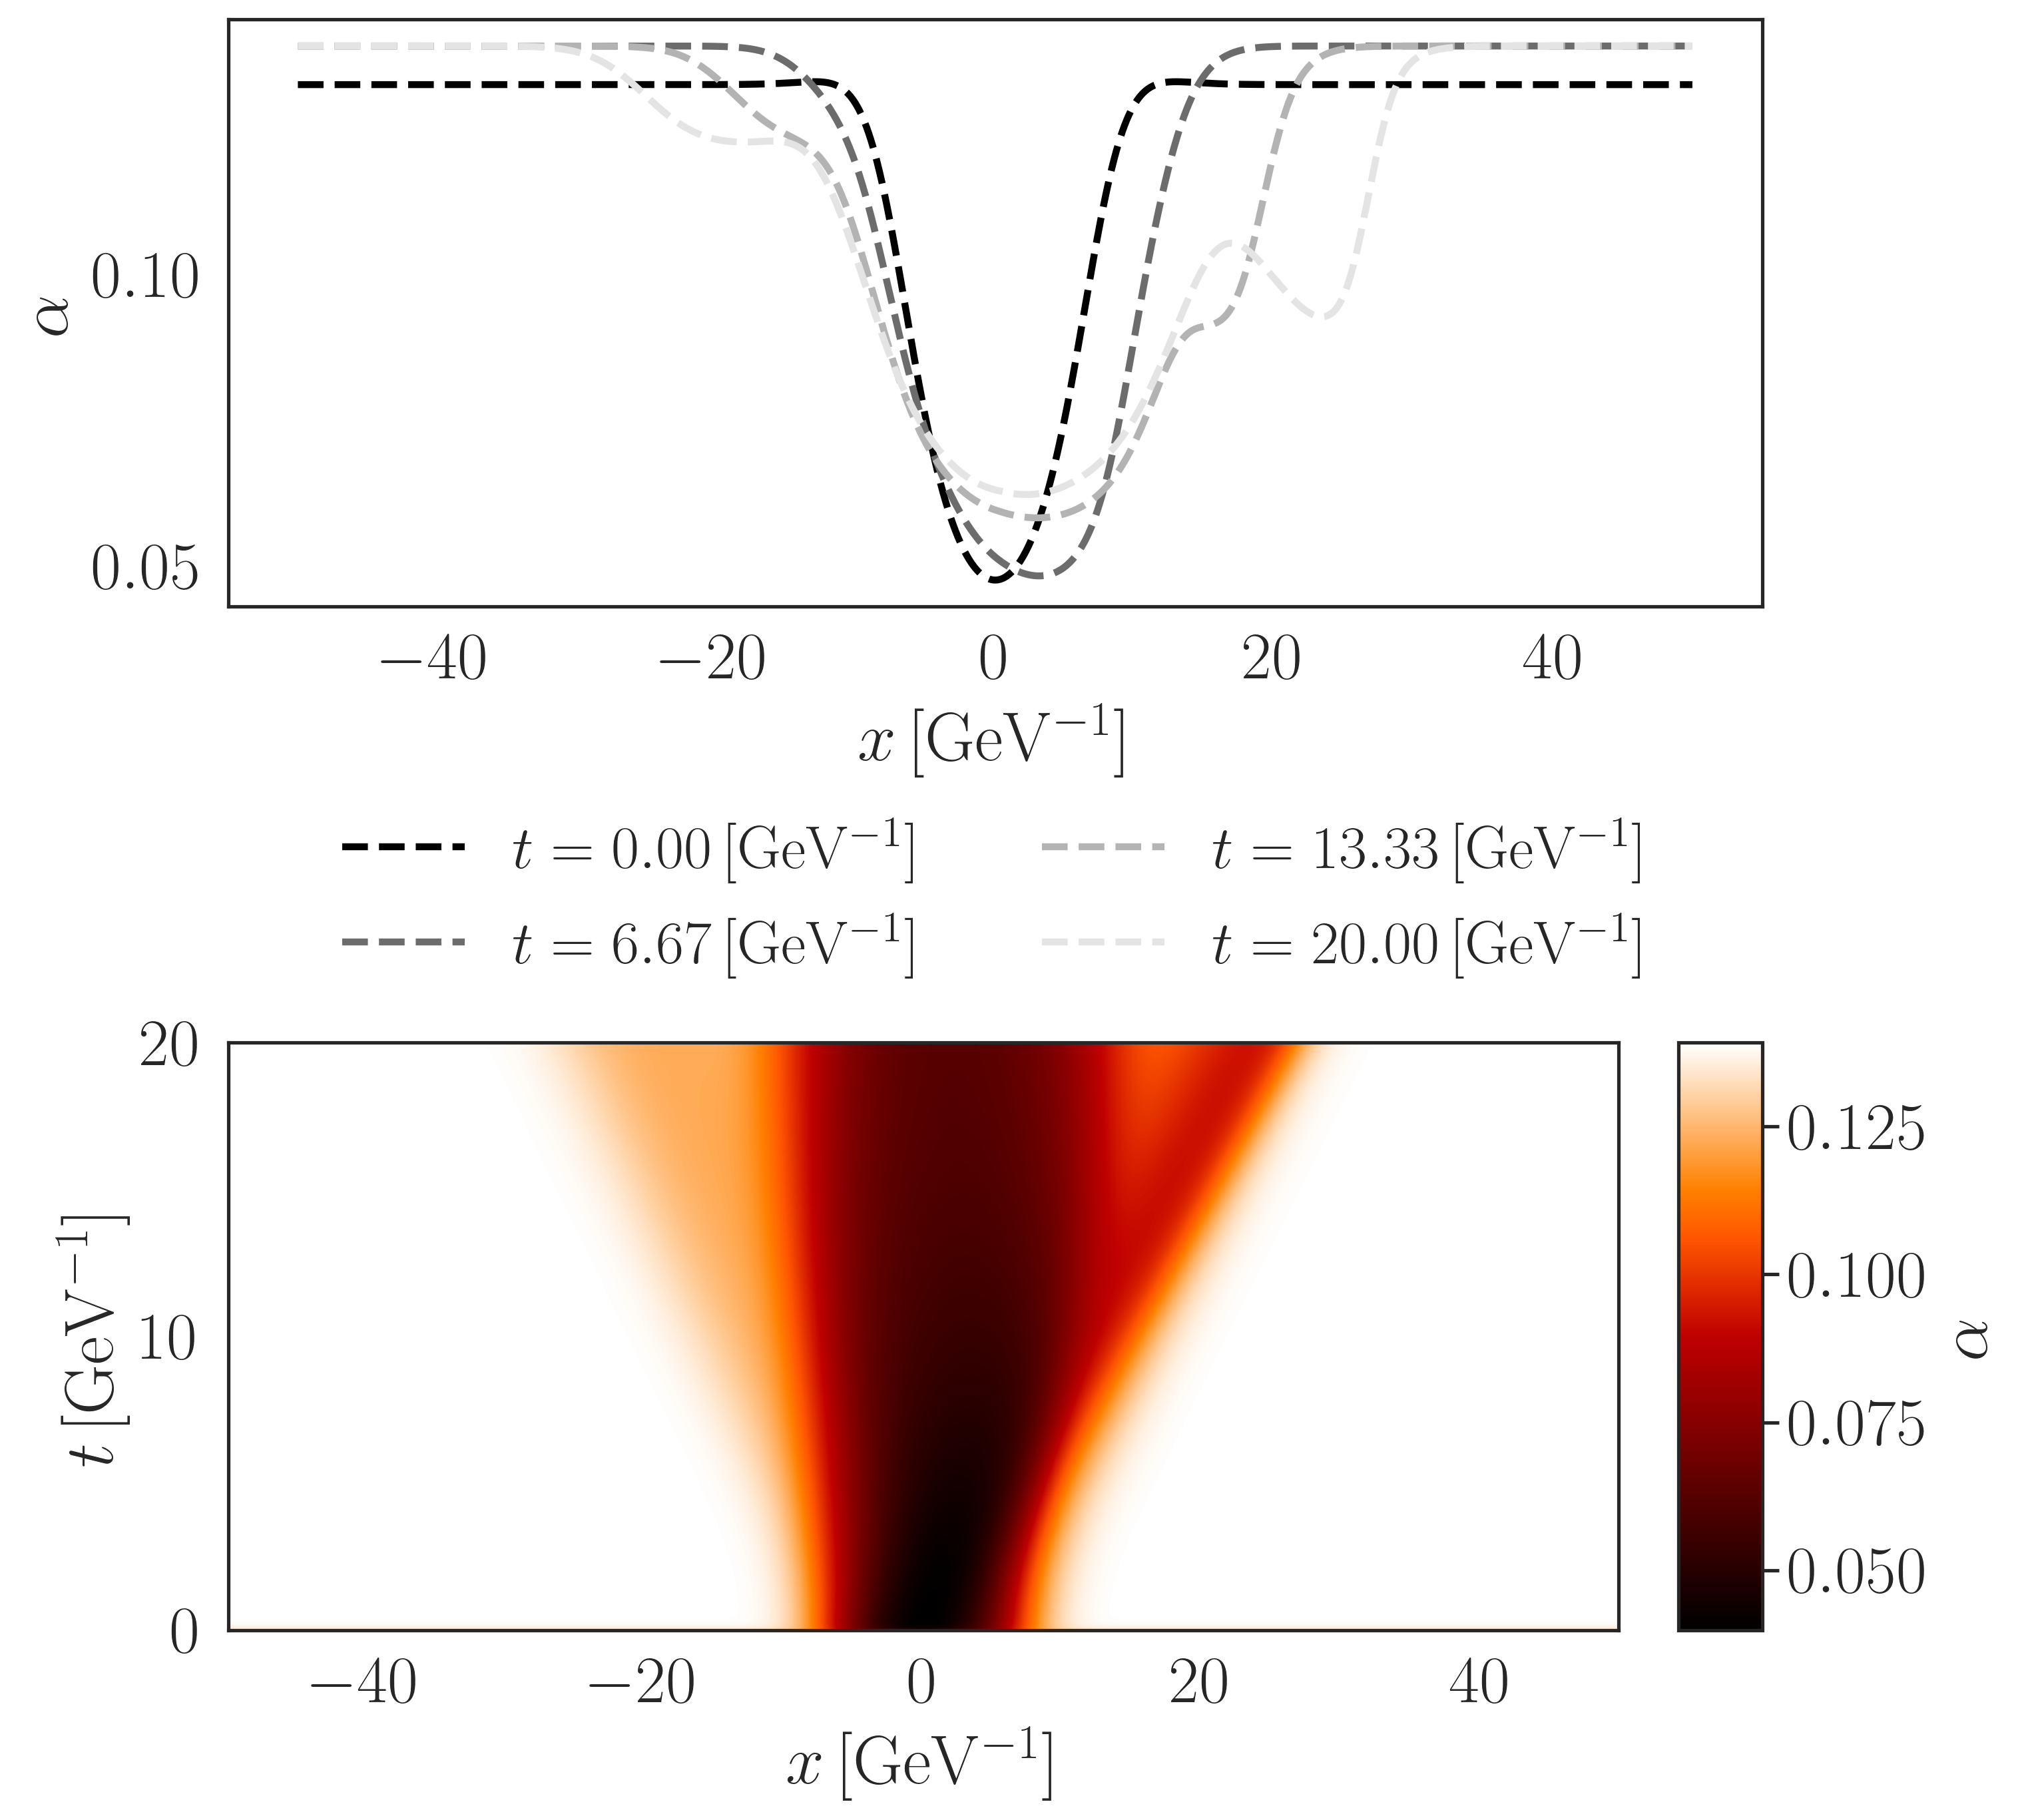

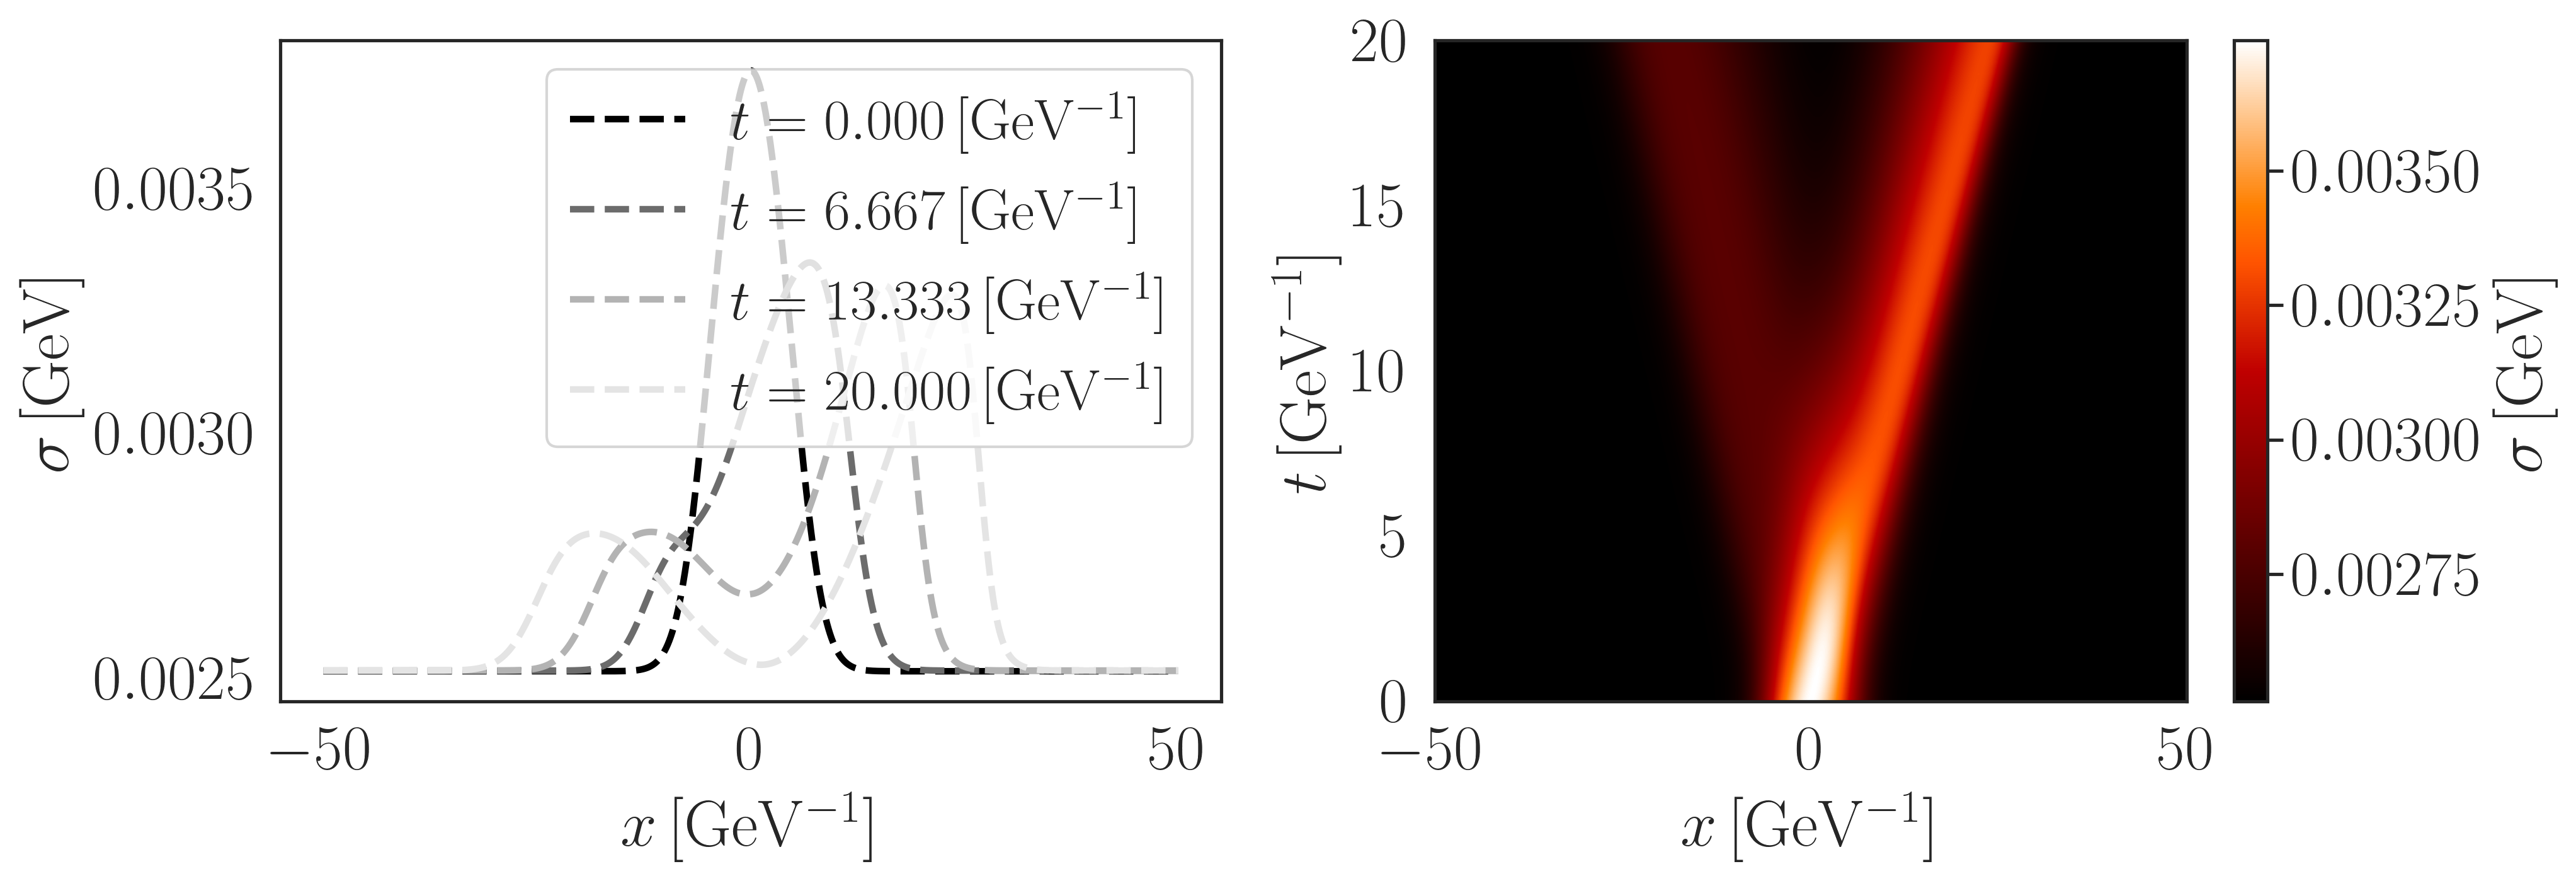

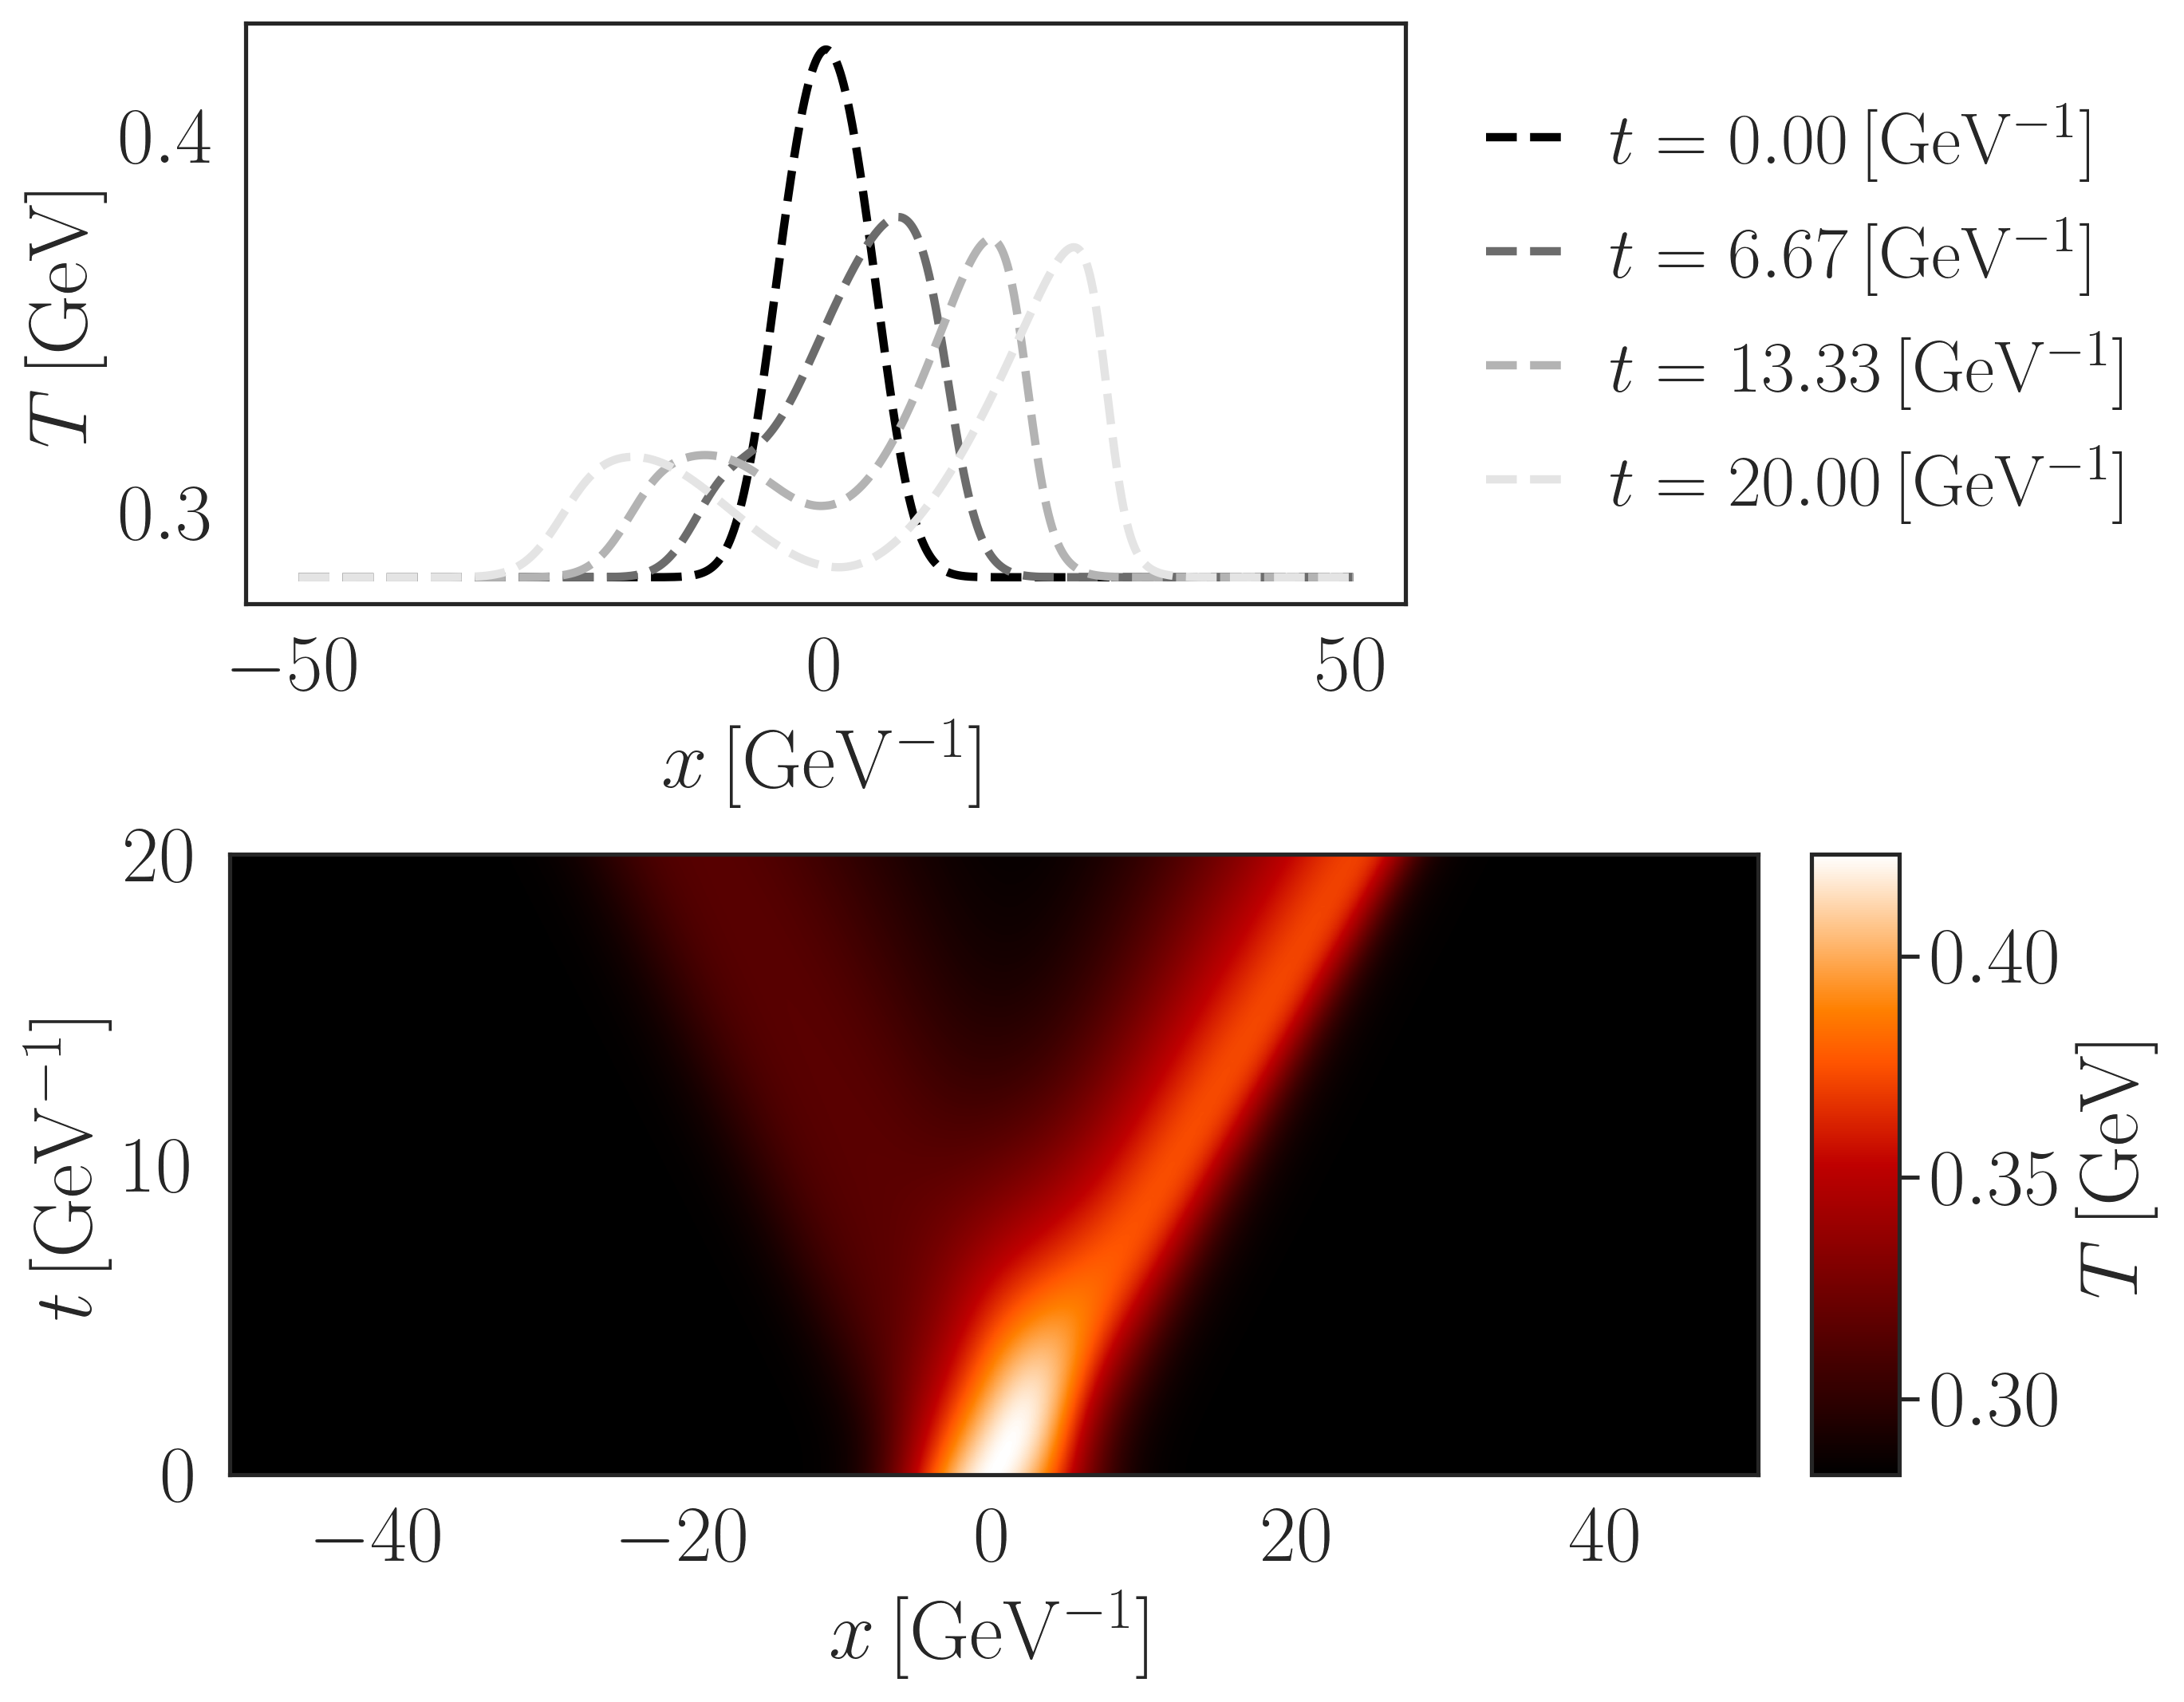

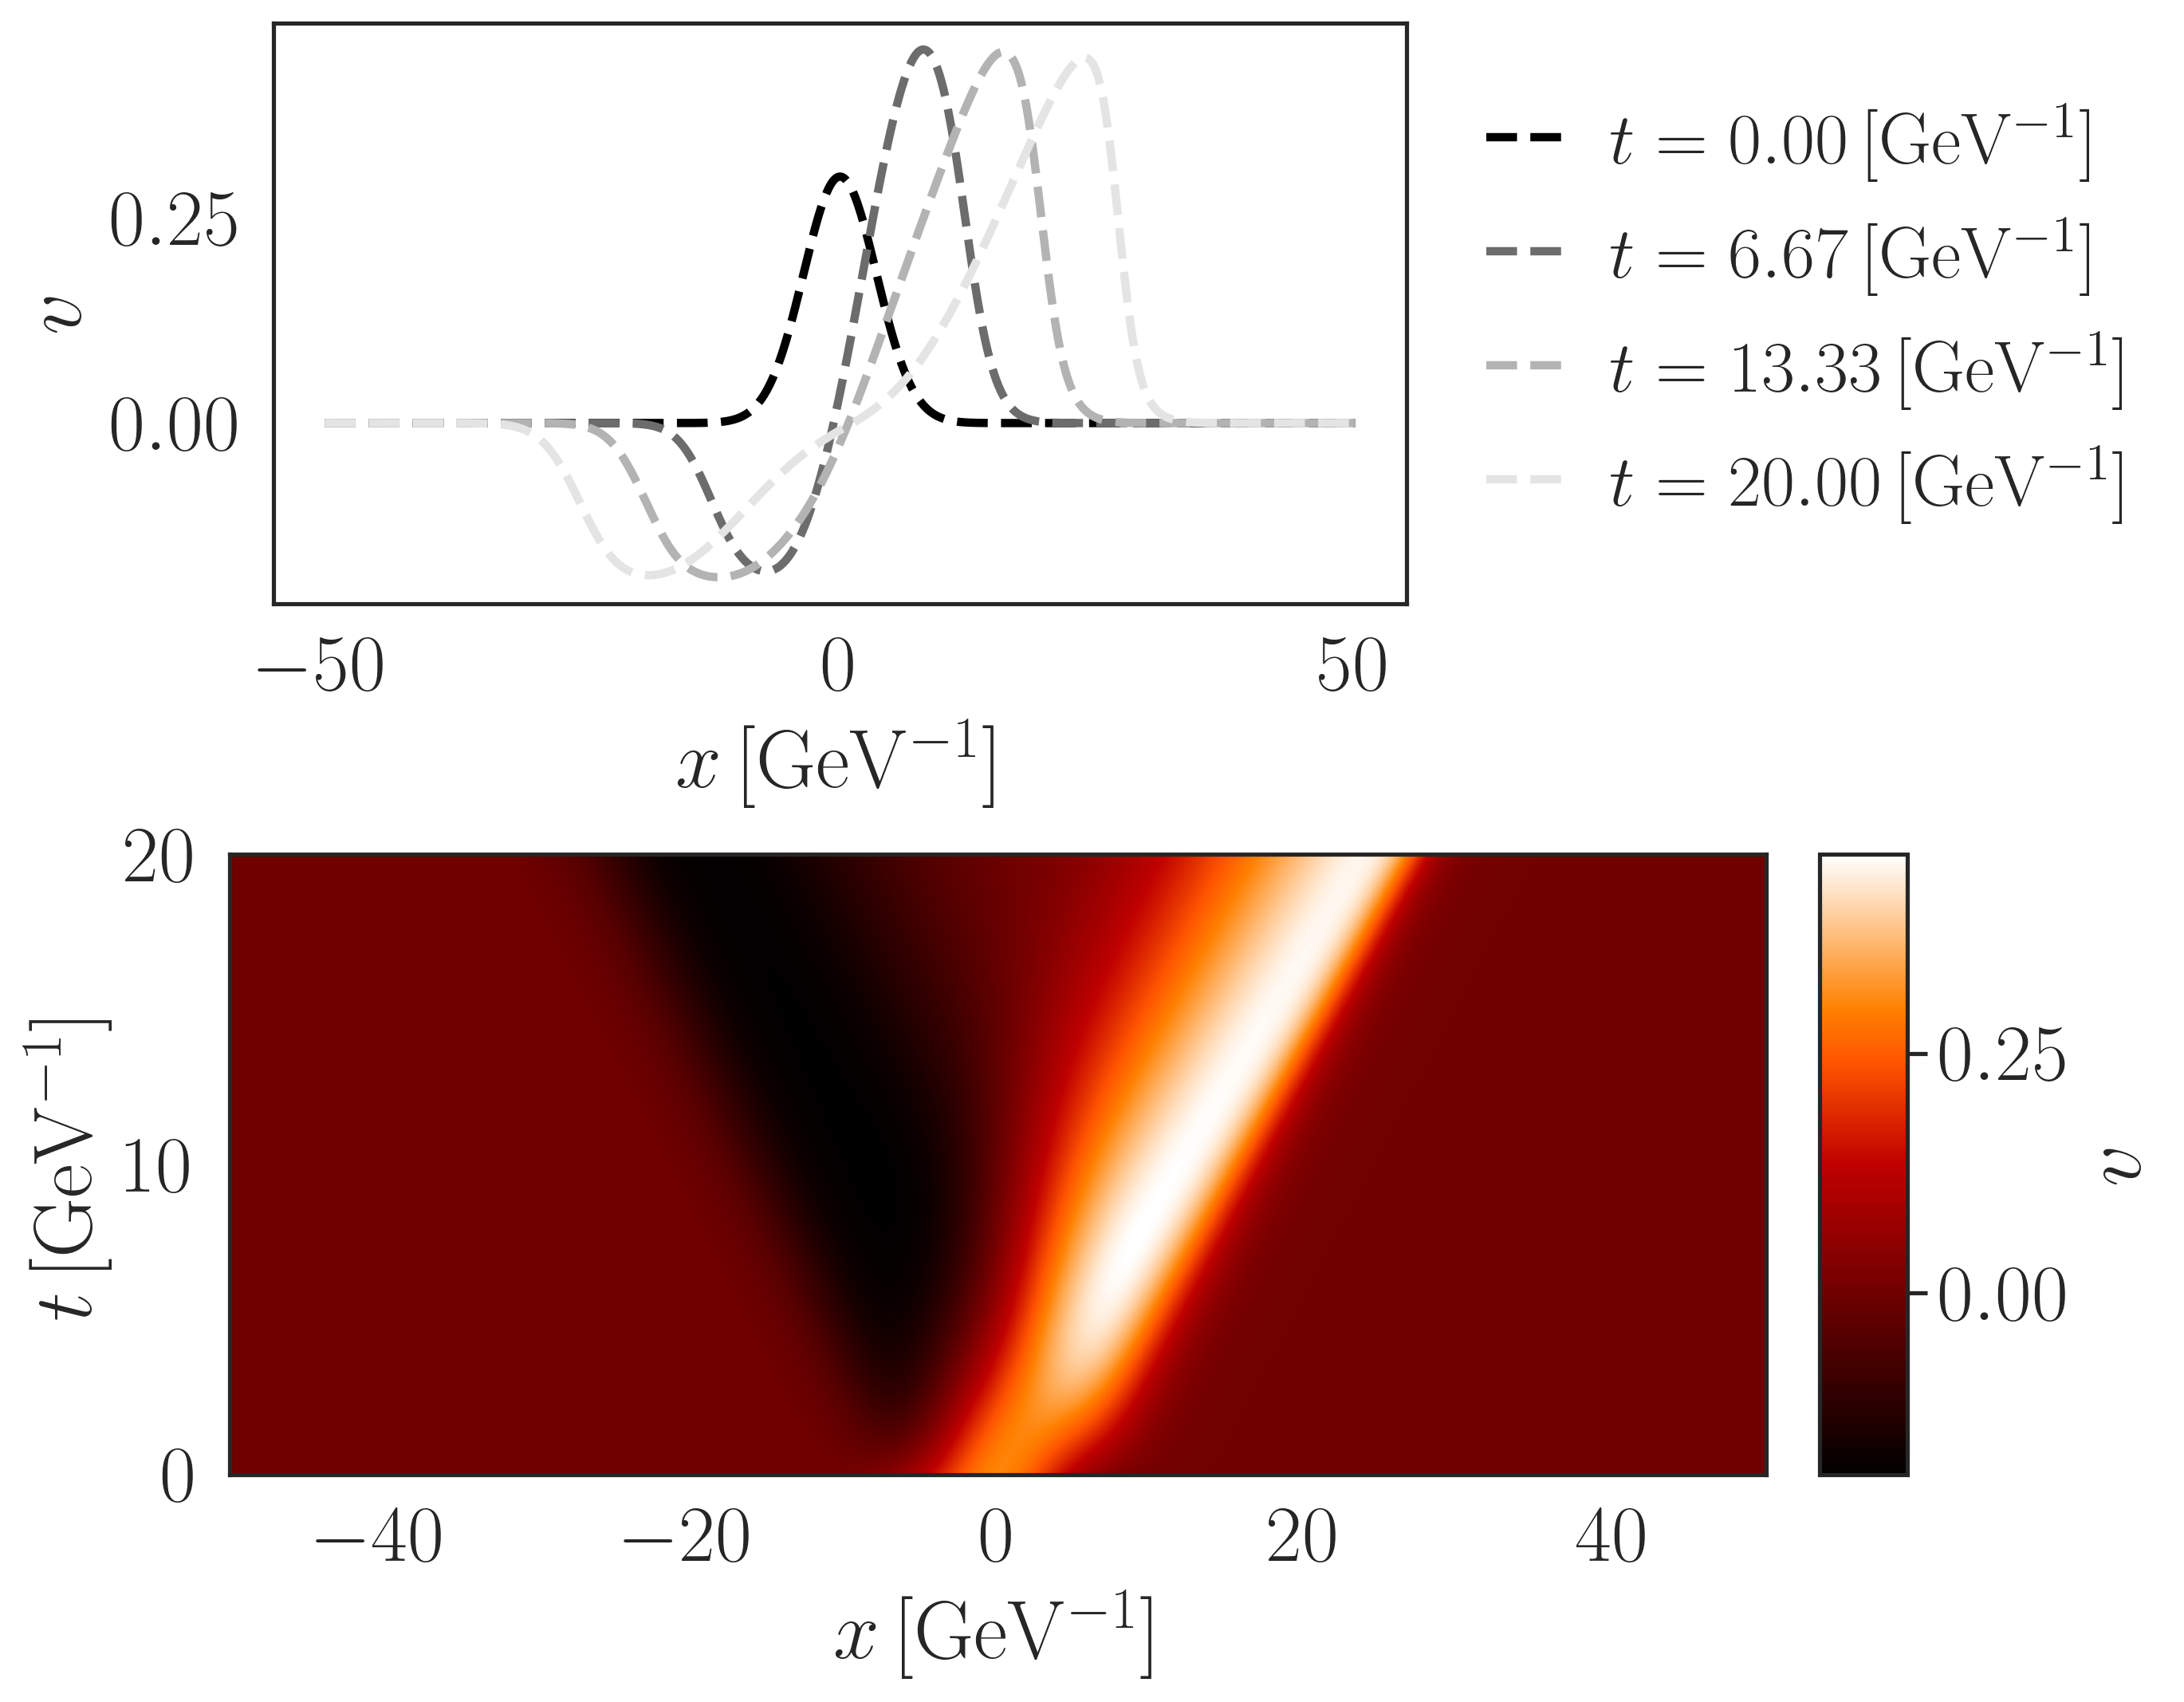

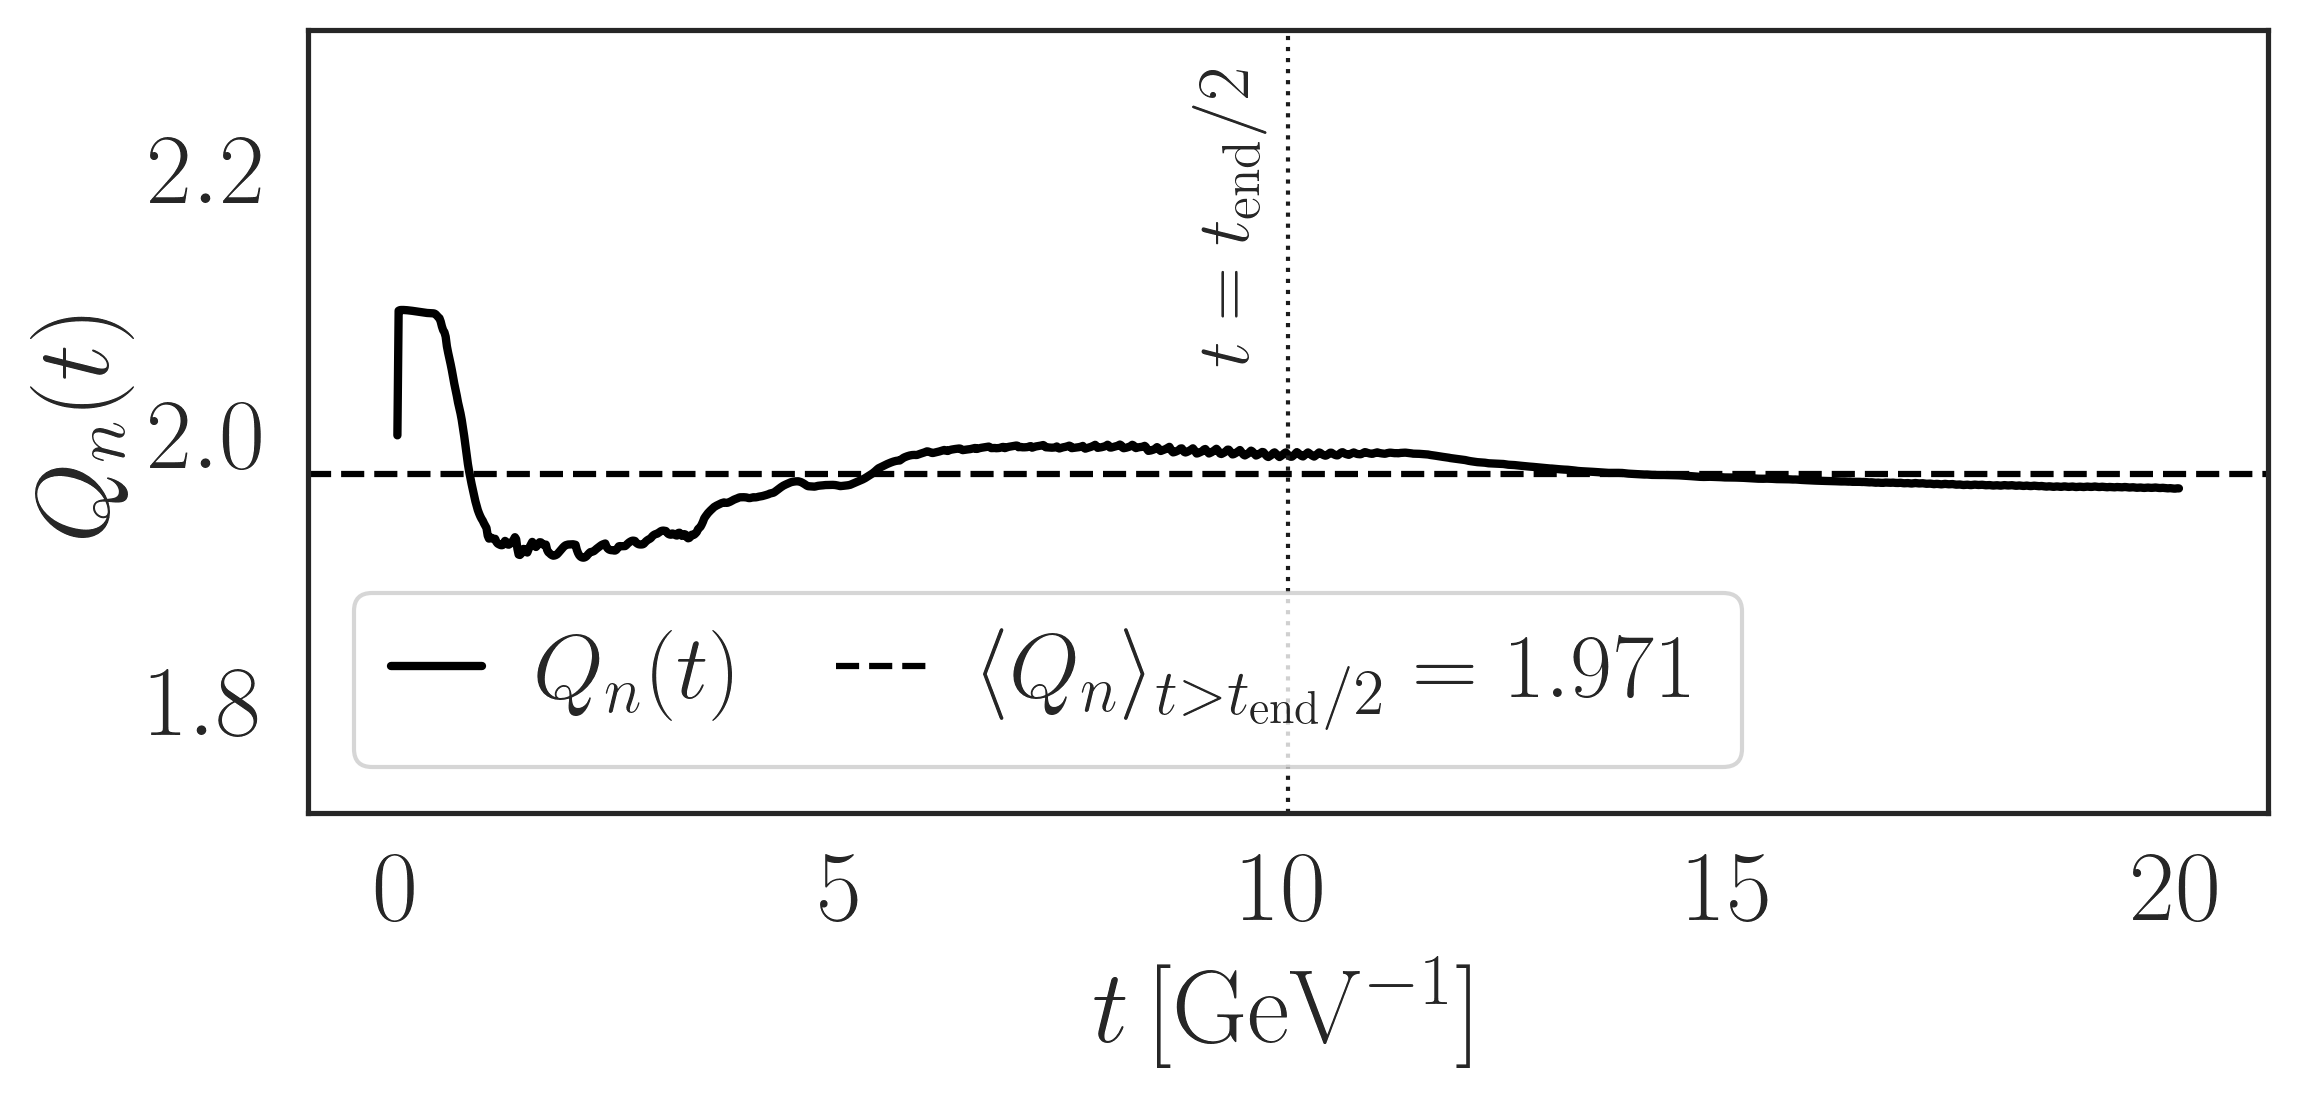

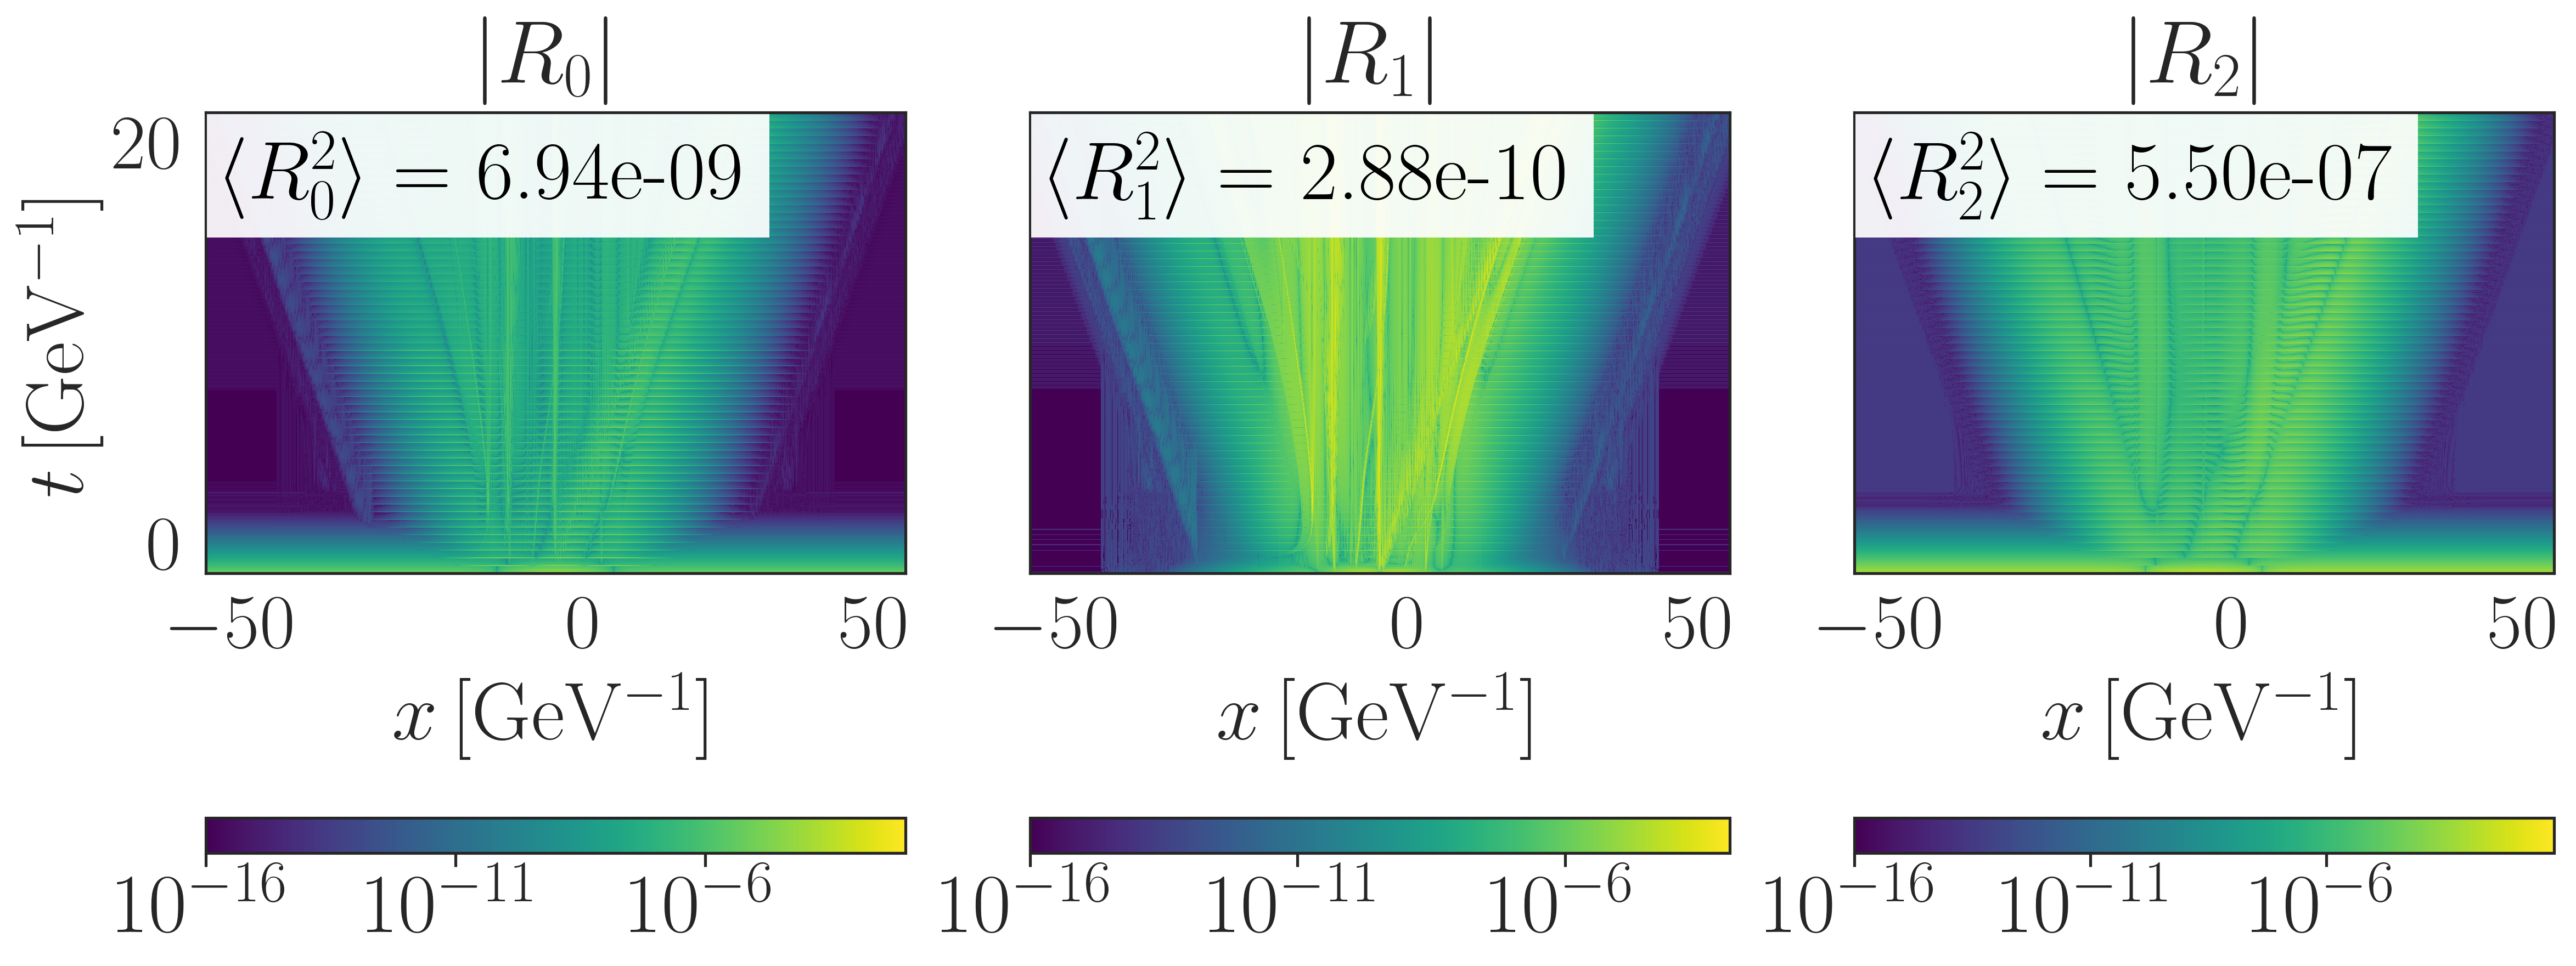

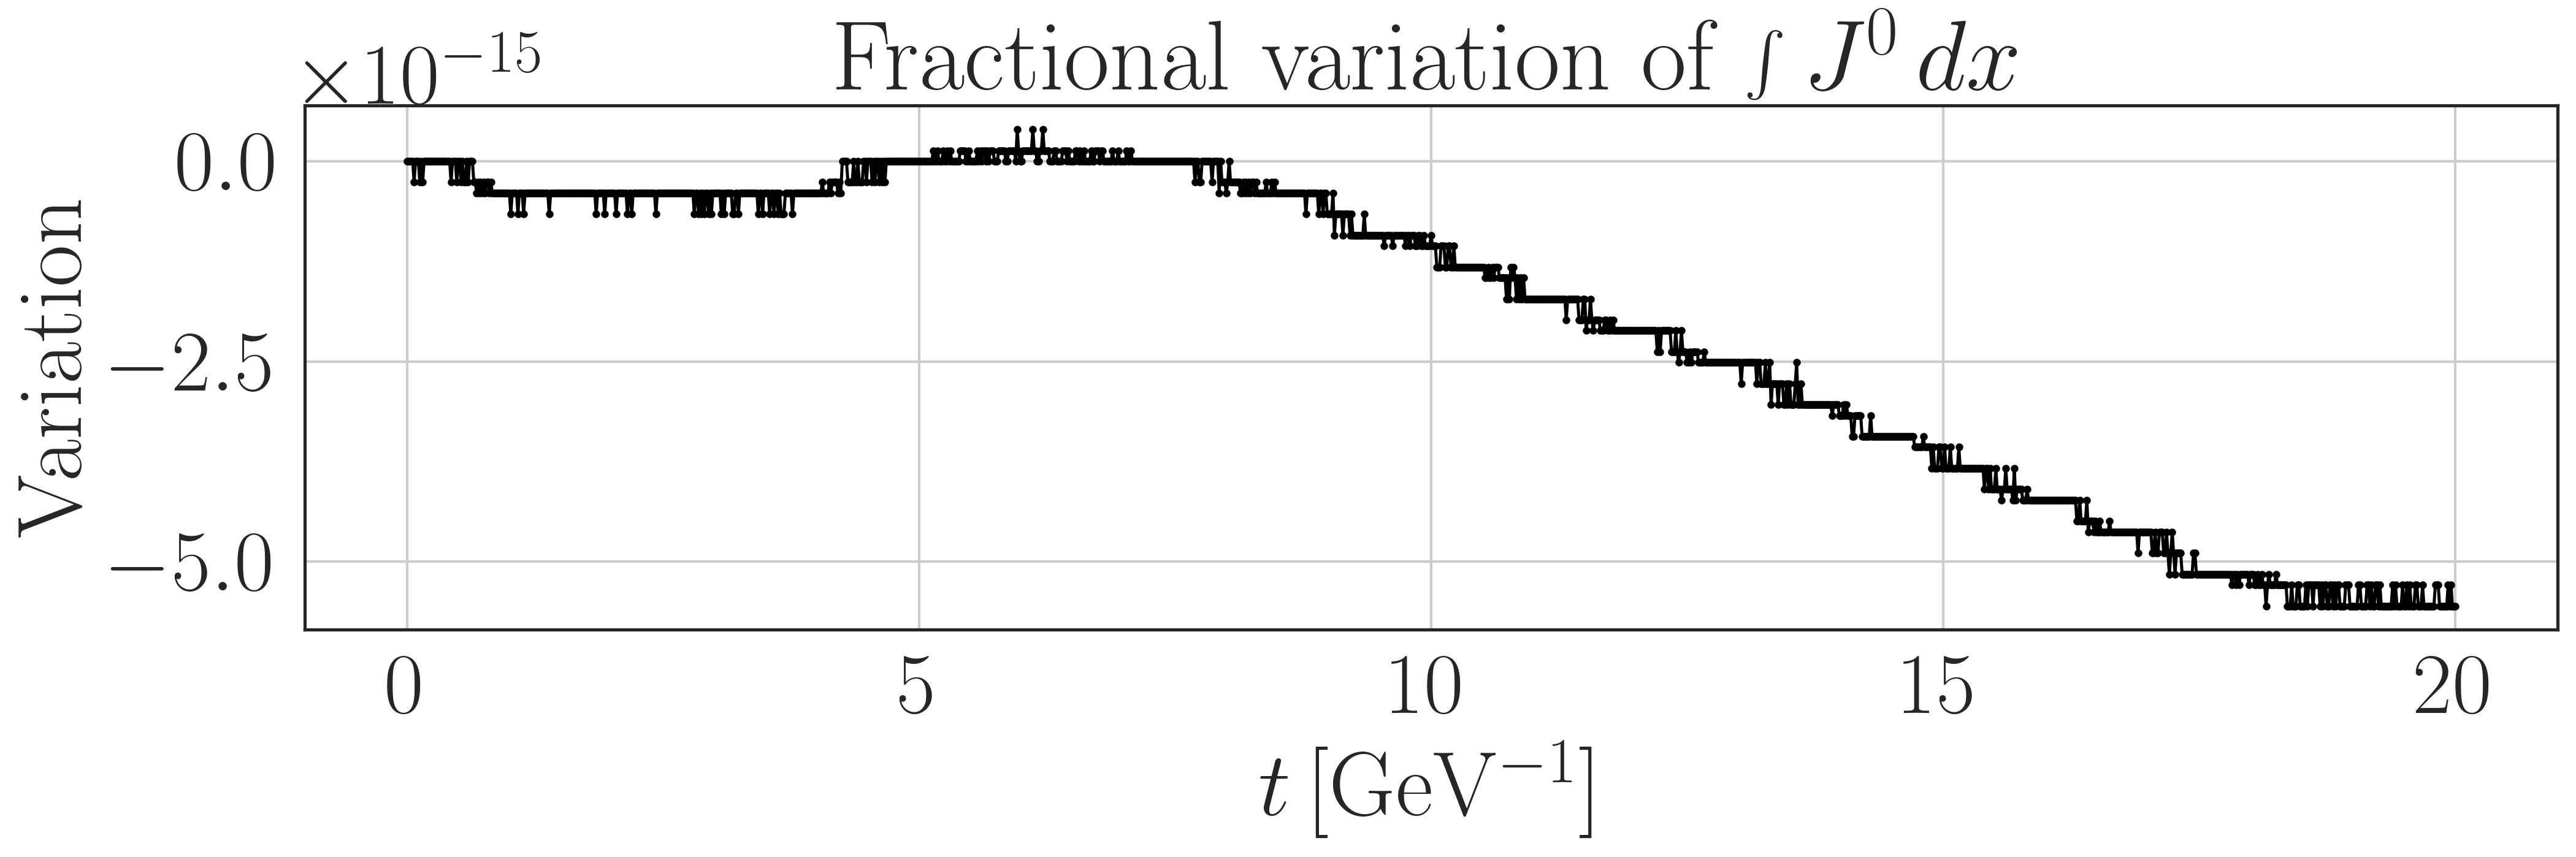

In [15]:
plt.rcParams.update({
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
})

t_full    = res3["t"]
xc_full   = res3["xc"]
dx_full   = xc_full[1] - xc_full[0]

n_full      = res3["n"]
alpha_full  = res3["alpha"]
J0_full     = res3["J0"]
T_full      = np.stack([T_func(tt, xc_full) for tt in t_full], axis=0)
v_full      = np.stack([v_func(tt, xc_full) for tt in t_full], axis=0)
sigma_full  = sigma_func(alpha_full, T_full)
lambd_full  = lambd_func(sigma_full)


# We can also dalculate, for example, all PDE residuals, just like we would do with a PINN solution (we use the highest resolution for this)

alpha_t_full  = np.gradient(alpha_full, t_full, axis=0)

stride_t, stride_x = 1, 1
t_plot      = t_full[::stride_t]
xc_plot     = xc_full[::stride_x]
n_plot      = n_full[::stride_t, ::stride_x]
alpha_plot  = alpha_full[::stride_t, ::stride_x]
sigma_plot  = sigma_full[::stride_t, ::stride_x]
T_plot      = T_full[::stride_t, ::stride_x]
v_plot      = v_full[::stride_t, ::stride_x]
J0_plot     = J0_full[::stride_t, ::stride_x]


Nt_plot      = len(t_plot) - 1
times_plot   = np.linspace(0, Nt_plot, 4, dtype=int)


# We now begin plotting. This is the color scale we use everywhere:
import matplotlib.cm as cm
cmap = cm.get_cmap("Greys_r", 256)
vals = np.interp(np.linspace(0, 1, 256), [0.0, 1/3, 2/3, 1.0],[0.0, 0.35, 0.59, 0.81])
cmap = cmap(vals)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(cmap)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(cmap)
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from matplotlib.colors import LinearSegmentedColormap
colors = [(0, "black"), (0.5, "white"), (1, "red")]
custom_cmap_2 = LinearSegmentedColormap.from_list("black_white_red", colors)

from matplotlib.ticker import ScalarFormatter


# Plot 1: 5 time slices of n(t,x), and spacetime colormap of n(t,x)

fig = plt.figure(figsize=(9, 7), constrained_layout=True)
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.48, 0.52], hspace=0.18)

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0],
                                          width_ratios=[1.15, 0.32], wspace=0.05)
ax_snap = fig.add_subplot(gs_top[0, 0])
ax_leg  = fig.add_subplot(gs_top[0, 1])

gs_bot = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1],
                                          width_ratios=[1.05, 0.06], wspace=0.05)
ax_heat = fig.add_subplot(gs_bot[0, 0])
cax     = fig.add_subplot(gs_bot[0, 1])

for i, ti in enumerate(times_plot):
    ax_snap.plot(xc_plot, n_plot[ti],
                 color=custom_cmap(i/(len(times_plot)-1)),
                 ls='--', lw=2.5,
                 label=fr'$t={t_plot[ti]:.2f}\,[\mathrm{{GeV^{{-1}}}}]$')
ax_snap.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_snap.set_ylabel(r'$n\,{\rm [GeV^{3}]}$')
ax_snap.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax_leg.axis('off')
h, l = ax_snap.get_legend_handles_labels()
ax_leg.legend(h, l, loc='center', ncol=1, frameon=False,
              handlelength=1.2, handletextpad=0.5)

pcm = ax_heat.pcolormesh(xc_plot, t_plot, n_plot, shading='auto', cmap='gist_heat')
ax_heat.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_heat.set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')
cb = fig.colorbar(pcm, cax=cax)
cb.set_label(r'$n\,{\rm [GeV^{3}]}$')
cb.ax.ticklabel_format(style='sci', scilimits=(0,0))

fig.canvas.draw()

offset = cb.ax.yaxis.get_offset_text()
txt = offset.get_text()
offset.set_visible(False)

cb.ax.text(3.63, -0.18, txt, transform=cb.ax.transAxes, ha='right', va='bottom', fontsize=offset.get_fontsize())

plt.show()


# Plot 2: Time slices of J^0(t,x), and spacetime colormap of J^0(t,x)

def thicken_features(A, radius=2, axis=1):
    k = 2*radius + 1
    kernel = np.ones(k, dtype=A.dtype) / k
    baseline = np.apply_along_axis(lambda v: np.convolve(v, kernel, mode='same'), axis, A)

    r = A - baseline
    shifts = range(-radius, radius+1)

    r_pos = np.maximum.reduce([np.maximum(np.roll(r, s, axis=axis), 0) for s in shifts])
    r_neg = np.minimum.reduce([np.minimum(np.roll(r, s, axis=axis), 0) for s in shifts])
    r_dil = np.where(r_pos >= -r_neg, r_pos, r_neg)

    return baseline + r_dil

fig = plt.figure(figsize=(9, 7), constrained_layout=True)
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.48, 0.52], hspace=0.18)

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0],
                                          width_ratios=[1.15, 0.32], wspace=0.05)
ax_snap = fig.add_subplot(gs_top[0, 0])
ax_leg  = fig.add_subplot(gs_top[0, 1])

gs_bot = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1],
                                          width_ratios=[1.05, 0.06], wspace=0.05)
ax_heat = fig.add_subplot(gs_bot[0, 0])
cax     = fig.add_subplot(gs_bot[0, 1])

for i, ti in enumerate(times_plot):
    ax_snap.plot(xc_plot, J0_plot[ti],
                 color=custom_cmap(i/(len(times_plot)-1)),
                 ls='--', lw=2.5,
                 label=fr'$t={t_plot[ti]:.2f}\,[\mathrm{{GeV^{{-1}}}}]$')
ax_snap.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_snap.set_ylabel(r'$J^{0}\,{\rm [GeV^{3}]}$')
ax_snap.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax_leg.axis('off')
h, l = ax_snap.get_legend_handles_labels()
ax_leg.legend(h, l, loc='center', ncol=1, frameon=False,
              handlelength=1.2, handletextpad=0.5)

shocks = False
if shocks == True:
    # When shocks are present, the features of J0 are too thin to appreciate, so we manually make them "thicker"
    J0_vis = thicken_features(J0_plot, radius=10, axis=1)
    pcm = ax_heat.pcolormesh(xc_plot, t_plot, J0_vis, shading='auto', cmap='gist_heat',
                        vmin=np.min(J0_plot)*0.8, vmax=np.max(J0_plot)*0.8)
else:
    pcm = ax_heat.pcolormesh(xc_plot, t_plot, J0_plot, shading='auto', cmap='gist_heat')
    
ax_heat.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_heat.set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')
cb = fig.colorbar(pcm, cax=cax)
cb.set_label(r'$J^{0}\,{\rm [GeV^{3}]}$')
cb.ax.ticklabel_format(style='sci', scilimits=(0,0))

fig.canvas.draw()

offset = cb.ax.yaxis.get_offset_text()
txt = offset.get_text()
offset.set_visible(False)

cb.ax.text(3.63, -0.18, txt, transform=cb.ax.transAxes, ha='right', va='bottom', fontsize=offset.get_fontsize())

plt.show()


# Plot 3: Time slices of alpha(t,x), and spacetime colormap of alpha(t,x)

fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs  = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[3, 0.8, 3], width_ratios=[1, 0.06])

ax_line = fig.add_subplot(gs[0, :])
ax_leg  = fig.add_subplot(gs[1, :])
ax_heat = fig.add_subplot(gs[2, 0])
cax     = fig.add_subplot(gs[2, 1])

for i, ti in enumerate(times_plot):
    ax_line.plot(
        xc_plot, alpha_plot[ti],
        color=custom_cmap(i/(len(times_plot)-1)), ls='--', lw=2.5,
        label=fr'$t={t_plot[ti]:.2f}\,[\mathrm{{GeV^{{-1}}}}]$'
    )
ax_line.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_line.set_ylabel(r'$\alpha$')

ax_leg.axis('off')
ax_leg.legend(*ax_line.get_legend_handles_labels(), loc='center', ncol=2, frameon=False)

pcm = ax_heat.pcolormesh(xc_plot, t_plot, alpha_plot, shading='auto', cmap='gist_heat')
fig.colorbar(pcm, cax=cax, label=r'$\alpha$')

ax_heat.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_heat.set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')

plt.show()


# Plot 4: Time slices of sigma(t,x), and spacetime colormap of sigma(t,x)

cmap  = custom_cmap
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i, ti in enumerate(times_plot):
    axs[0].plot(xc_plot, sigma_plot[ti],
                color=cmap(i/(len(times_plot)-1)), lw=2.5, ls='--',
                label=f'$t={t_plot[ti]:.3f}'r'\,{\rm [GeV^{-1}]}$')
axs[0].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[0].set_ylabel(r'$\sigma\,{\rm [GeV]}$')
axs[0].legend(loc='upper right')

pcm = axs[1].pcolormesh(xc_plot, t_plot, sigma_plot, shading='auto', cmap='gist_heat')
fig.colorbar(pcm, ax=axs[1], label=r'$\sigma\,{\rm [GeV]}$')
axs[1].set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
axs[1].set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')

plt.tight_layout()
plt.show()


# Plot 5: Time slices of T(t,x), and spacetime colormap of T(t,x)

fig = plt.figure(figsize=(9, 7), constrained_layout=True)
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.48, 0.52], hspace=0.18)

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0],
                                          width_ratios=[1.15, 0.32], wspace=0.05)
ax_snap = fig.add_subplot(gs_top[0, 0])
ax_leg  = fig.add_subplot(gs_top[0, 1])

gs_bot = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1],
                                          width_ratios=[1.05, 0.06], wspace=0.05)
ax_heat = fig.add_subplot(gs_bot[0, 0])
cax     = fig.add_subplot(gs_bot[0, 1])

for i, ti in enumerate(times_plot):
    ax_snap.plot(xc_plot, T_plot[ti],
                 color=custom_cmap(i/(len(times_plot)-1)),
                 ls='--', lw=2.5,
                 label=fr'$t={t_plot[ti]:.2f}\,[\mathrm{{GeV^{{-1}}}}]$')
ax_snap.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_snap.set_ylabel(r'$T\,{\rm [GeV]}$')

ax_leg.axis('off')
h, l = ax_snap.get_legend_handles_labels()
ax_leg.legend(h, l, loc='center', ncol=1, frameon=False,
              handlelength=1.2, handletextpad=0.5)

pcm = ax_heat.pcolormesh(xc_plot, t_plot, T_plot, shading='auto', cmap='gist_heat')
ax_heat.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_heat.set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')
cb = fig.colorbar(pcm, cax=cax)
cb.set_label(r'$T\,{\rm [GeV]}$')

plt.show()


# Plot 6: Time slices of v(t,x), and spacetime colormap of v(t,x)

fig = plt.figure(figsize=(9, 7), constrained_layout=True)
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.48, 0.52], hspace=0.18)

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0],
                                          width_ratios=[1.15, 0.32], wspace=0.05)
ax_snap = fig.add_subplot(gs_top[0, 0])
ax_leg  = fig.add_subplot(gs_top[0, 1])

gs_bot = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1],
                                          width_ratios=[1.05, 0.06], wspace=0.05)
ax_heat = fig.add_subplot(gs_bot[0, 0])
cax     = fig.add_subplot(gs_bot[0, 1])

for i, ti in enumerate(times_plot):
    ax_snap.plot(xc_plot, v_plot[ti],
                 color=custom_cmap(i/(len(times_plot)-1)),
                 ls='--', lw=2.5,
                 label=fr'$t={t_plot[ti]:.2f}\,[\mathrm{{GeV^{{-1}}}}]$')
ax_snap.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_snap.set_ylabel(r'$v$')

ax_leg.axis('off')
h, l = ax_snap.get_legend_handles_labels()
ax_leg.legend(h, l, loc='center', ncol=1, frameon=False,
              handlelength=1.2, handletextpad=0.5)

pcm = ax_heat.pcolormesh(xc_plot, t_plot, v_plot, shading='auto', cmap='gist_heat')
ax_heat.set_xlabel(r'$x\,{\rm [GeV^{-1}]}$')
ax_heat.set_ylabel(r'$t\,{\rm [GeV^{-1}]}$')
cb = fig.colorbar(pcm, cax=cax)
cb.set_label(r'$v$')

plt.show()


# Plot 7: Convergence test (L1)

fig, ax = plt.subplots(figsize=(8, 4))

t0, t1 = float(np.nanmin(t_Q)), float(np.nanmax(t_Q))
fraction_cut = 1/2  # Average only after this fraction of the run
t_cut = t0 + fraction_cut*(t1 - t0)
mask_time = t_Q >= t_cut

def mean_after_cut(Q):
    m = mask_time & np.isfinite(Q)
    return float(np.nanmean(Q[m])) if np.any(m) else np.nan

Qn_mean_L1 = mean_after_cut(Q_n_L1)

col_l1 = 'black'

ax.plot(t_Q, Q_n_L1, lw=2, color=col_l1, label=r'$Q_n(t)$')
if np.isfinite(Qn_mean_L1):
    ax.axhline(Qn_mean_L1, ls='--', lw=1.5, color=col_l1,
               label=rf'$\langle Q_n\rangle_{{t>t_{{\rm end}}/{int(1/fraction_cut)}}}={Qn_mean_L1:.3f}$')
ax.set_xlabel(r'$t\,{\rm [GeV^{-1}]}$')
ax.set_ylabel(r'$Q_n(t)$')
ax.set_ylim(
    min((1.8, 0.9*np.nanmin(Q_n_L1))) if not shocks else min((0.0, 0.9*np.nanmin(Q_n_L1))),
    max((2.2, 1.1*np.nanmax(Q_n_L1))) if not shocks else max((1.2, 1.1*np.nanmax(Q_n_L1)))
)
ax.legend(ncol=2, columnspacing=1, handlelength=1, handletextpad=0.6, loc='lower left')

ax.axvline(t_cut, ls=':', color='k', lw=1)
ax.annotate(rf'$t=t_{{\rm end}}/{int(1/fraction_cut)}$',
            xy=(t_cut, 0.5), xycoords=('data', 'axes fraction'),
            xytext=(-5, 13), textcoords='offset points',
            rotation=90, ha='right', va='bottom',
            clip_on=False, zorder=5)

plt.tight_layout()
plt.show()


# Plot 8: PINN-style residual

from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
import matplotlib.transforms as mtransforms

plt.rcParams.update({
    "axes.titlesize": 39,
    "axes.labelsize": 36,
    "xtick.labelsize": 34,
    "ytick.labelsize": 34,
})

def ddx_per(A, dx):
    return (np.roll(A, -1, axis=1) - np.roll(A, 1, axis=1)) / (2.0*dx)
    
gamma       = gamma_func(v_full)
alpha_t     = np.gradient(alpha_full, t_full, axis=0)
alpha_x     = ddx_per(alpha_full, dx_full)
at_plus_vax = alpha_t + v_full * alpha_x

gamma_n   = gamma * n_full
gamma_nv  = gamma * n_full * v_full

flux_l_t  = gamma**2 * lambd_full * T_full * at_plus_vax
flux_l_x  = gamma**2 * v_full * lambd_full * T_full * at_plus_vax

Wt        = -alpha_t + gamma**2 * at_plus_vax
Wx        =  alpha_x + gamma**2 * v_full * at_plus_vax
flux_s_t  = sigma_full * T_full * Wt
flux_s_x  = sigma_full * T_full * Wx

d_gn_dt   = np.gradient(gamma_n,  t_full, axis=0)
d_gnv_dx  = ddx_per(gamma_nv,     dx_full)
d_lt_dt   = np.gradient(flux_l_t, t_full, axis=0)
d_lx_dx   = ddx_per(flux_l_x,     dx_full)
d_st_dt   = np.gradient(flux_s_t, t_full, axis=0)
d_sx_dx   = ddx_per(flux_s_x,     dx_full)

R_array   = d_gn_dt + d_gnv_dx + d_lt_dt + d_lx_dx - d_st_dt - d_sx_dx
R0        = np.abs(R_array) / np.max(np.abs(alpha_full[0, :])) + 1e-16

t_inner = slice(1, -1)
x_inner = slice(1, -1)
t_vec   = t_full[t_inner]
x_vec   = xc_full[x_inner]

J0_t    = np.gradient(J0_full, t_full, axis=0)
N_x_full = -alpha_x
N_0_full = N_0_func(lambd_full, sigma_full, T_full, J0_full, n_full, N_x_full, v_full)
Jx_full = Jx_func(n_full, sigma_full, lambd_full, T_full, N_x_full, N_0_full, v_full)
Jx_x    = ddx_per(Jx_full, dx_full)
R1      = np.abs(J0_t + Jx_x) / np.max(np.abs(J0_full[0, :])) + 1e-16
R2      = np.abs(alpha_t + N_0_full) / np.max(np.abs(alpha_full[0, :])) + 1e-16

labels = [r"$|R_0|$", r"$|R_1|$", r"$|R_2|$"]
data   = [R0, R1, R2]

fig, axs = plt.subplots(1, 3, figsize=(15.5, 5.5),
                        sharey=True, constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.025, h_pad=0.00,
                                wspace=0.035, hspace=0.00)

for i, (ax, lab, res) in enumerate(zip(axs, labels, data)):
    res_abs = np.clip(np.abs(res))
    im = ax.pcolormesh(
        xc_full, t_full, res_abs,
        shading='auto',
        cmap='viridis',
        norm=LogNorm()
    )

    ax.set_title(lab, pad=13)
    ax.set_xlabel(r"$x\,[\mathrm{GeV^{-1}}]$")
    if i == 0:
        ax.set_ylabel(r"$t\,[\mathrm{GeV^{-1}}]$")
    else:
        ax.tick_params(labelleft=False)

    ax.text(
        0.028, 0.957,
        rf"$\langle R^2_{{{i}}} \rangle = $ {np.mean(res_abs**2):.2e}",
        color='black', fontsize=36, fontweight='bold',
        ha='left', va='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.93,
                  edgecolor='none', pad=8.0)
    )

    cbar = fig.colorbar(
        im, ax=ax, orientation='horizontal',
        fraction=1, pad=0.06,
        ticks=LogLocator(numticks=3)
    )
    cbar.ax.tick_params(labelsize=37)

    fig.canvas.draw()
    shift_pts   = 13
    offset_unit = fig.dpi_scale_trans
    xticks = ax.get_xticks()
    x0, x1 = ax.get_xlim()
    xmid = 0.5 * (x0 + x1)

    for val, lbl in zip(xticks, ax.get_xticklabels()):
        sgn = 1 if val < xmid else (-1 if val > xmid else 0)
        dx = (sgn * shift_pts) / 72.0
        lbl.set_transform(lbl.get_transform() + mtransforms.ScaledTranslation(dx, 0, offset_unit))

    yticks = ax.get_yticks()
    y0, y1 = ax.get_ylim()
    ymid = 0.5 * (y0 + y1)

    for val, lbl in zip(yticks, ax.get_yticklabels()):
        sgn = 1 if val < ymid else (-1 if val > ymid else 0)
        dy = (sgn * shift_pts) / 72.0
        lbl.set_transform(lbl.get_transform() + mtransforms.ScaledTranslation(0, dy, offset_unit))

plt.show()


# Plot 9: Mass conservation check

mass_J0_full = J0_full.sum(axis=1) * dx_full
t_mass  = t_full[::stride_t]
m_curve = mass_J0_full[::stride_t]

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
m0 = m_curve[0]
if m0 == 0:
    ax.plot(t_mass, m_curve - m0, '-o', ms=2, lw=1.2, color='black')
    ax.set_ylabel(r'Variation of $\int J^0\,dx$')
else:
    frac = (m_curve - m0) / m0
    ax.plot(t_mass, frac, '-o', ms=2, lw=1.2, color='black')
    ax.set_ylabel(r'Variation')
    ax.set_title(r'Fractional variation of $\int J^0\,dx$')
ax.set_xlabel(r'$t\,{\rm [GeV^{-1}]}$')
ax.grid(True)
plt.tight_layout()
plt.show()

In [16]:
print(f"Charge conserved up to a fraction of {max(np.abs((m_curve - m0) / m0)):.1e}")

Charge conserved up to a fraction of 5.6e-15


We will now export the data in a way that allows for an easy L2 error calculation between the KT and PINN solutions. We use the highest resolution available, and match the PINN's grid.

In [17]:
Nt_eval = 200
Nx_eval = 200
t_eval = np.linspace(0.0, t_end, Nt_eval)
x_edges_eval = np.linspace(-L, L, Nx_eval + 1)
x_eval = 0.5 * (x_edges_eval[:-1] + x_edges_eval[1:])

t_fine   = res3["t"]
xc_fine  = res3["xc"]
n_fine   = res3["n"]
J0_fine  = res3["J0"]

def interp_time_to(t_src, y_tj, t_q):
    return np.interp(t_q, t_src, y_tj)

def periodic_interp_space(x_src, y_x, x_q, L):
    xq = ((x_q + L) % (2*L)) - L

    x_ext = np.concatenate([x_src - 2*L, x_src, x_src + 2*L])
    y_ext = np.concatenate([y_x,        y_x,    y_x])
    
    return np.interp(xq, x_ext, y_ext)

Nt_fine, Nx_fine = n_fine.shape
n_at_te   = np.empty((Nt_eval, Nx_fine), dtype=np.float64)
J0_at_te  = np.empty((Nt_eval, Nx_fine), dtype=np.float64)

for j in range(Nx_fine):
    n_at_te[:, j]  = interp_time_to(t_fine,  n_fine[:, j],  t_eval)
    J0_at_te[:, j] = interp_time_to(t_fine,  J0_fine[:, j], t_eval)

n_grid  = np.empty((Nt_eval, Nx_eval), dtype=np.float64)
J0_grid = np.empty((Nt_eval, Nx_eval), dtype=np.float64)

for it in range(Nt_eval):
    n_grid[it, :]  = periodic_interp_space(xc_fine, n_at_te[it, :],  x_eval, L)
    J0_grid[it, :] = periodic_interp_space(xc_fine, J0_at_te[it, :], x_eval, L)

# Save to ~/Desktop as kt_data.npz
kt_out_path = os.path.expanduser("~/Desktop/kt_data.npz")
np.savez_compressed(
    kt_out_path,
    t_eval=t_eval.astype(np.float64),
    x_eval=x_eval.astype(np.float64),
    n_grid=n_grid.astype(np.float64),
    J0_grid=J0_grid.astype(np.float64),
    L=float(L), t_end=float(t_end),
)
print(f"[KT save] Wrote: {kt_out_path}")

[KT save] Wrote: /Users/faridchomali/Desktop/kt_data.npz
